<a href="https://colab.research.google.com/github/taceroc/light_echo_modeling/blob/main/LE_pw_density_func.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib


from astropy.coordinates import (cartesian_to_spherical, SkyCoord, Distance, Galactic, EarthLocation, AltAz, CartesianRepresentation, SphericalRepresentation)
from astropy import units as u
# Calculate observer's local sidereal time (LST)
from astropy.time import Time
from astropy.coordinates import EarthLocation

%config InlineBackend.figure_format='retina'

In [2]:
Deltat = [300] # days
dtoy = 0.00273973 # 1 day = 0.00273973 y
Deltat_y = np.array(Deltat) * dtoy
z0 = [-0.10, 0, 0.3, 1] # pc
pctoly = 3.26156 # 1pc = 3.26156 light-year
z0ly = np.array(z0) * pctoly
# -- point where the plane-parallel slab of dust intersects the line of sight
# -- inclination of the plane, is perpendicular to the line of sight (I am using 89 so the tangent don't die)
alpha = 0.0*np.pi/180  # angle of tilt in radians
a = np.tan(alpha)
dt0 = 50 * dtoy
dz0 = 0.02 * pctoly # in ly

c = 1 # in light-year / year
pctom = 3.086e+16
n = 2.3 * (100 ** 3) #m-3
n = n * ( pctom ** 3 ) / ( pctoly ** 3 )
sigma = 5e-22 / (100 ** 2) #m2 #RR paper
sigma = ( sigma / ( (pctom ** 2) ) ) * ( pctoly ** 2 )
albedo = 0.6
Fphi = 1/4 * np.pi
# -- distance source - observer
dkpc = 5 #kpc
d = dkpc * 1000 * pctoly

k = sigma * albedo * Fphi
# L = 15,000 x 3.9e26 # watts = kg m ^2 / s^3
L = (15000 * 3.9e36) * ((60 * 60 * 24 * 365) ** 3) * (pctoly ** 2) / (pctom ** 2)
Ir = k * L * c / (4 * np.pi * (dkpc * 1000 * pctoly)**2)

# Make the density a picewise function that depend on the angle phi

In [3]:
def nh_phi(params, phi_min = 0, phi_max = 2*np.pi, n_h = n):
  """
    Define the density as a pairwise function that depends on the angle phi, the angle in the x,y sky plane
    Arguments
        params: list/array/tuple with the phi angle to be evaluate
        phi_min: min phi where the density value exist
        phi_max: min phi where the density value exist
        n_h: density value
    Return
        Value of the density with same shape as params
  """
  # n_h_array = np.ones(len(params)) * n_h
  nh = (((phi_min <= params) & (params <= phi_max)))
  arr = np.array(nh, dtype=bool)
  int_arr = arr.astype(int)
  return int_arr * n_h


In [4]:
def surface_brightness_plane(Deltat_y, z0ly, dz0, phi_min, phi_max):
  """
    Arguments
        Deltat_y: time when the snap of the LE is taken by observer, in year
        z0ly: sitance of the dust in light-years
        dz0: thickness of the plane dust
        phi_min: inferior limit where the dust is located in the sky plane
        phi_max: superior limit where the dust is located in the sky plane
  """

  phi = np.linspace(0, 2*np.pi, 100)


  surface = np.zeros((len(Deltat_y), len(z0ly), 100))
  for j, time in enumerate(Deltat_y):
    ct = time * c
    for i, z in enumerate(z0ly):
      if z < 0:
        print(z)
        ti = (-2 * z)/(c * (1 + a**2))
        # print(ti)
        if time >= ti:
          print(z)
          r_le = np.sqrt(2 * z * ct + (ct)**2 * (1 + a**2) )
          print(r_le)
          x = r_le * np.cos(phi) - a * ct
          # -- distance source - dust
          r = z - a * x + ct
          # -- rho = x^2 + y^2 = r_le
          rhodrho  = 0.5 * (dz0 - a * x + c * dt0)
          # print(len(x), len(theta))
          surface[j, i, :] = Ir * nh_phi(phi, phi_min, phi_max) * dz0 / ( 4 * np.pi * r * rhodrho)
        elif time < ti:
          surface[j, i, :] = Ir * nh_phi(phi, phi_min, phi_max) * np.zeros(len(phi))
      elif z >= 0:
        ti = 0
        if time >= 0:
          r_le = np.sqrt(2 * z * ct + (ct)**2 * (1 + a**2))
          print((ct / c) / dtoy)
          x = r_le * np.cos(phi) - a * ct
          # print(x)
          # -- distance source - dust
          r = z - a * x + ct
          # print(r)
          # -- rho = x^2 + y^2 = r_le
          rhodrho  = 0.5 * (dz0 - a * x + c * dt0)
          # print(rhodrho)
          surface[j, i, :] = Ir * nh_phi(phi, phi_min, phi_max) * dz0 / ( 4 * np.pi * r * rhodrho)
          # print(j, i, surface[j, i, :])

  return surface



In [5]:
phi_min, phi_max = (55 / 180) * np.pi, (240 / 180) * np.pi
surface = surface_brightness_plane(Deltat_y, z0ly, dz0,  phi_min, phi_max)

-0.326156
-0.326156
0.37336740060294493
300.0
300.0
300.0


In [6]:
np.mean(surface, axis=2)

array([[1.62815489e+17, 9.82066303e+16, 4.48336360e+16, 1.97669427e+16]])

In [7]:
mean = []
std = []
for j, time in enumerate(Deltat_y):
  for i, z in enumerate(z0ly):
    if np.mean(surface[j, i, :]) != 0:
      # print(np.mean(np.log(surface[j, i, :])))
      mean.append(np.log(np.mean(surface[j, i, :])))
      # std.append(np.std(np.log(surface[j, i, :])))
    else:
      mean.append(np.mean(surface[j, i, :]))
      # std.append(np.std(surface[j, i, :]))

surface_norm = (mean - np.min(mean)) / (np.max(mean) - np.min(mean))
surface_norm = np.array(surface_norm).reshape(len(Deltat),len(z0ly))

In [8]:
surface_norm

array([[1.        , 0.76024743, 0.38838334, 0.        ]])

In [9]:
def r_outin(z, ct, dz0, dt0, a, inout):
    if inout == "out":
      size = 1
    else:
      size = -1
    r_le_outin = np.sqrt(2 * z * ct + (ct)**2 * (1 + a**2) + (size) * 2 * (dz0 / 2) * ct)
    # -- include the thickness in xy plane
    r_le_outin = r_le_outin + (size) * (2 * dz0 * ct + 2 * z * c * (dt0) + 2 * ct * (dt0) * (1 + a**2)) / (r_le_outin * 4 )
    # -- in arcseconds 5kpc = 16308 ly
    # -- degree to arcseconds
    r_le_outin = np.arctan(r_le_outin / d) * (180 / np.pi) * 3600

    return r_le_outin

In [10]:
def xy_plane_ring(angle, z, ct, dz0, dt0, a, d):
    """
      x and y coordinates in the sky plane of the LE ring. When the dust is a plane.

      Arguments:
        angle: angle in the sky plane where the LE is define
        z: position of the dust plane in ly
        ct: time when the "snap" of the LE is taken from the observer in years
        dz0: thickness of the dust plane in ly
        dt0: duration of the flash light (source) in yeaars
        a: tan(alpha) -  alpha: angle between the normal of the dust plane and the line of sight (z axis)
        d: distance in ly between the source and the obsever

      Returns:
        xs, ys: x and y position in the sky plane in arcseconds

    """
    # -- radii LE ring as seen by z including the thickness of 0.02
    r_le_out = r_outin(z, ct, dz0, dt0, a, "out")
    # -- radii LE ring as seen by z including the thickness of 0.02
    r_le_in = r_outin(z, ct, dz0, dt0, a, "in")
    radii = [r_le_out, r_le_in]
    xs = np.outer(radii, np.cos(angle)) - a * ct
    ys = np.outer(radii, np.sin(angle))
    # in order to have a closed area, the circles
    # should be traversed in opposite directions
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]

    return xs, ys

def plot_plane_dust(ax, d, xs, ys, z, surface_norm, surface, j, i):
    ax.set_xlim(np.arctan(-4/d) * (180 / np.pi) * 3600 , np.arctan(4/d) * (180 / np.pi) * 3600)
    ax.set_ylim(np.arctan(-4/d) * (180 / np.pi) * 3600 , np.arctan(4/d) * (180 / np.pi) * 3600)
    # ax.fill(np.ravel(xs), np.ravel(ys), lw=0, color=cmap(normalize(surface_norm[j,i])), alpha = 0.3)
    xxx = xs.copy()
    yyy = ys.copy()
    xxx[1,:] = xxx[1,::-1]
    yyy[1,:] = yyy[1,::-1]
    new_xs = xxx.copy()[:,(surface[j,i,:] > 0)]
    new_xs[1,:] = new_xs[1,::-1]
    new_ys = yyy.copy()[:,(surface[j,i,:] > 0)]
    new_ys[1,:] = new_ys[1,::-1]
    ax.fill(np.ravel(new_xs), np.ravel(new_ys), lw=0, color=cmap(normalize(surface_norm[j,i])), label="%s"%(z/pctoly))
    ax.text(0, 40, r"$\phi$ = [%s, %s]"%(  int((phi_min * 180) / np.pi), int((phi_max * 180) / np.pi)))
    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4)

    return ax

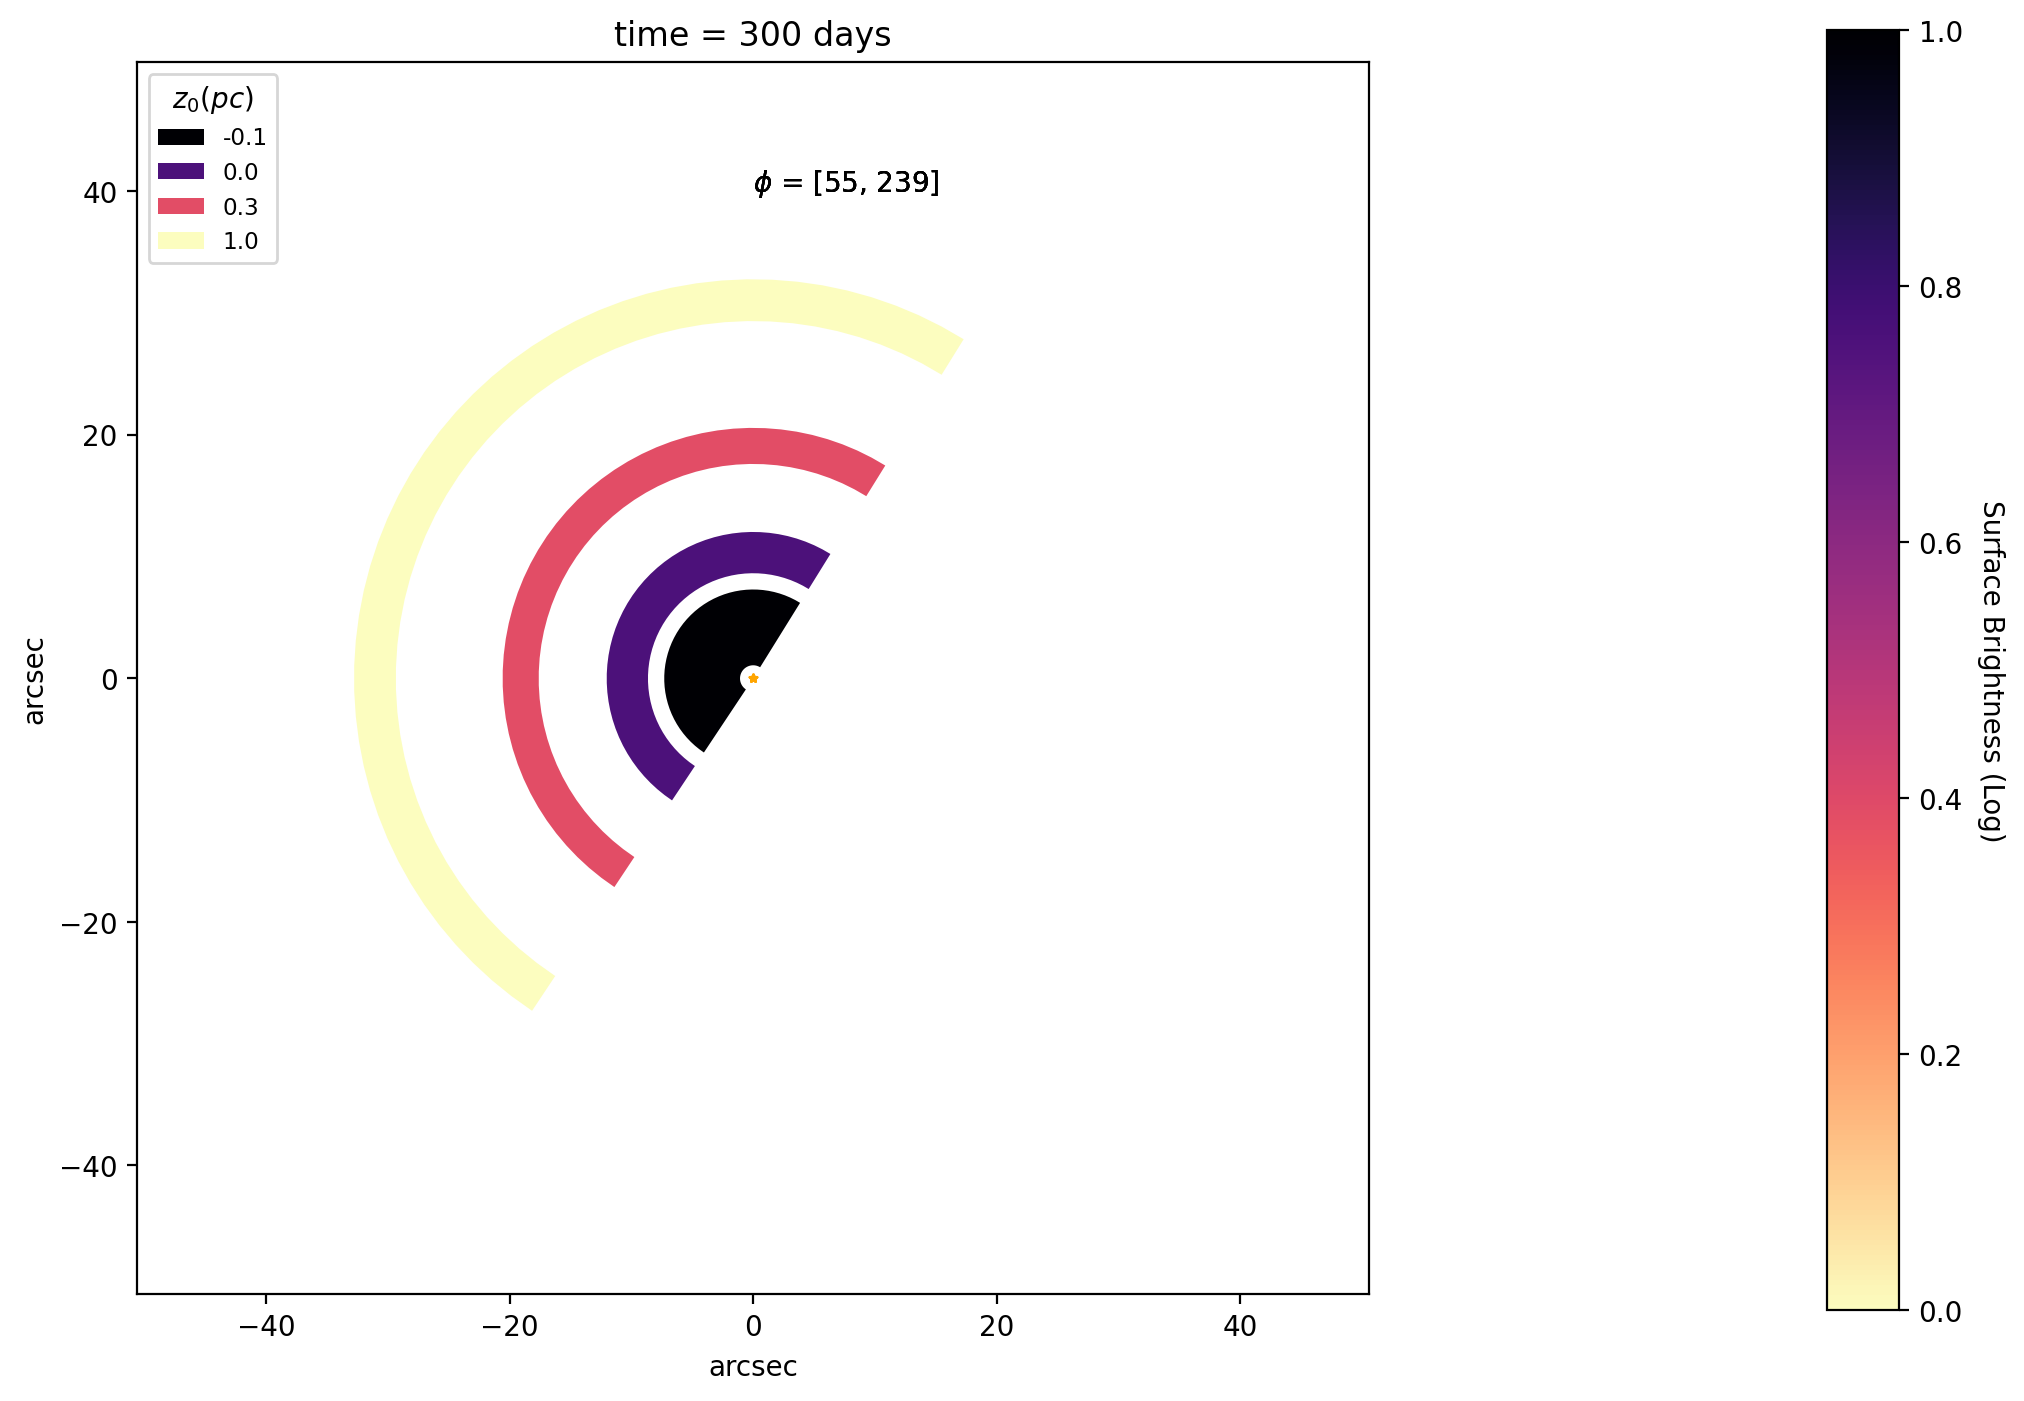

In [11]:
angle = np.linspace(0, 2*np.pi, 100)
cmap = matplotlib.colormaps.get_cmap('magma_r')
nonzero = [np.mean(surface, axis=2) != 0]
surface_norm_nonzero = surface_norm[tuple(nonzero)]
normalize = matplotlib.colors.Normalize(vmin=surface_norm_nonzero.min(), vmax=surface_norm_nonzero.max())

XX = []
YY = []
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
for j, time in enumerate(Deltat_y):
  ct = time*c
  ax.set_title("time = %s days"%int(time/ dtoy))
  for i,z in enumerate(z0ly):
      if z < 0:
        # -- time ring star expanding
        ti = (-2 * z)/(c * (1 + a**2))
        # print(ti)
        if time >= ti:
          xs, ys = xy_plane_ring(angle, z, ct, dz0, dt0, a, d)
          XX.append(xs)
          YY.append(ys)
          plot_plane_dust(ax, d, xs, ys, z, surface_norm, surface, j, i)
          ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4)
        else:
          ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
      else:
        ti = dt0
        # -- for time less than the duration of the flash light, all the dust within the paraboiloid define for the dust and the source would be illuminated.
        if time <= ti:
          # -- rin and rout for the most inner ring keeps the same
          index = [k for k, x in enumerate(z0ly) if x >= 0]
          if i == index[0]:
            print(i, z0ly[i] / pctoly)
            xs, ys = xy_plane_ring(angle, z, ct, dz0, dt0, a, d)
            XX.append(xs)
            YY.append(ys)
            plot_plane_dust(ax, d, xs, ys, z, surface_norm, surface, j, i)
            ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
            ax.legend(loc='upper left', ncol=1, fontsize='small', title = r"$z_0 (pc)$")
          else:
            # -- for the rest of the rings, rin is rout of the previous ring
            r_le_out = r_outin(z, ct, dz0, dt0, a, "out")
            r_le_in = r_outin(z0ly[i-1], ct, dz0, dt0, a, "out")
            print(z / pctoly, z0ly[i-1] / pctoly, r_le_out, r_le_in)
            radii = [r_le_out, r_le_in]
            xs = np.outer(radii, np.cos(angle)) - a * ct
            ys = np.outer(radii, np.sin(angle))
            # in order to have a closed area, the circles
            # should be traversed in opposite directions
            xs[1,:] = xs[1,::-1]
            ys[1,:] = ys[1,::-1]
            XX.append(xs)
            YY.append(ys)
            plot_plane_dust(ax, d, xs, ys, z, surface_norm, surface, j, i)
            ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
            ax.legend(loc='upper left', ncol=1, fontsize='small', title = r"$z_0 (pc)$")
        elif time > ti:
          xs, ys = xy_plane_ring(angle, z, ct, dz0, dt0, a, d)
          XX.append(xs)
          YY.append(ys)
          plot_plane_dust(ax, d, xs, ys, z, surface_norm, surface, j, i)
          ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
          ax.legend(loc='upper left', ncol=1, fontsize='small', title = r"$z_0 (pc)$")



cbax = fig.add_axes([0.96, 0.1, 0.03, 0.80])

ax.set_xlabel("arcsec")
ax.set_ylabel("arcsec")
ax.set_box_aspect(1)

cb = matplotlib.colorbar.ColorbarBase(cbax, cmap=cmap, norm=normalize, orientation='vertical')
cb.set_label("Surface Brightness (Log)", rotation=270, labelpad=15)

# def label_cbrt(x,pos):
#     return "{:.1f}".format(np.log10(np.exp((( x * (np.max(mean) - np.min(mean)) )+ (np.min(mean)) ))))

def label_cbrt(x,pos):
    return "{:.1f}".format(x)

cb.formatter = matplotlib.ticker.FuncFormatter(label_cbrt)
cb.update_ticks()
# plt.tight_layout()
# plt.savefig("figure2.png", dpi = 700, bbox_inches='tight')

plt.show()

In [12]:
len(XX)

4

# Fix surface area

[A Three-dimensional Study Using Light Echoes of the Structure of the Interstellar Medium in Front of SN 1987A. Xu et al, 1995 ](https://articles.adsabs.harvard.edu/pdf/1995ApJ...451..806X)

[Observability of Scattered-Light Echoes around Variable Stars and Cataclysmic Events. Sugerman 2003](https://iopscience.iop.org/article/10.1086/378358/pdf)




$\Delta z = \frac{\sqrt{\Delta \rho ^2 - d\rho_t^2}}{k}$

$\Delta z$: thickness of the dust plane

$\Delta \rho$: observable thicknes of the LE

$d\rho_t$: thickness due to the duration of the flash light ($\Delta t$)

$k = \frac{d\rho}{dz} = \frac{ct}{\rho}$

$\Delta \rho^2 =(\frac{ct}{\rho})^2 \Delta z^2 + (\frac{\rho}{2t} + \frac{c^2t}{2\rho})^2 \Delta t ^2$


In [13]:
ct = Deltat_y * c
rho = np.sqrt(2 * z0ly * ct + (ct)**2 * (1 + a**2) )
half_obs_thickness = np.sqrt( (ct / rho) ** 2 * dz0 ** 2 + ( (rho * c / 2 * ct) + ( c * ct / 2 * rho )) ** 2 * dt0  ** 2 ) / 2

In [14]:
def r_outin(z, ct, dz0, dt0, a, inout):
    if inout == "out":
      size = 1
    else:
      size = -1
    # rho = np.sqrt(2 * z * ct + (ct)**2 * (1 + a**2) )
    r_le_outin = np.sqrt(2 * z * ct + (ct)**2 * (1 + a**2) + (size) * 2 * (dz0 / 2) * ct)
    half_obs_thickness = np.sqrt( (ct / r_le_outin) ** 2 * dz0 ** 2 + ( (r_le_outin * c / 2 * ct) + ( c * ct / 2 * r_le_outin )) ** 2 * dt0  ** 2 ) / 2
    # -- include the thickness in xy plane
    r_le_outin = r_le_outin + (size) * half_obs_thickness
    # -- in arcseconds 5kpc = 16308 ly
    # -- degree to arcseconds
    r_le_outin = np.arctan(r_le_outin / d) * (180 / np.pi) * 3600

    return r_le_outin

-0.326156
200.0
200.0
200.0


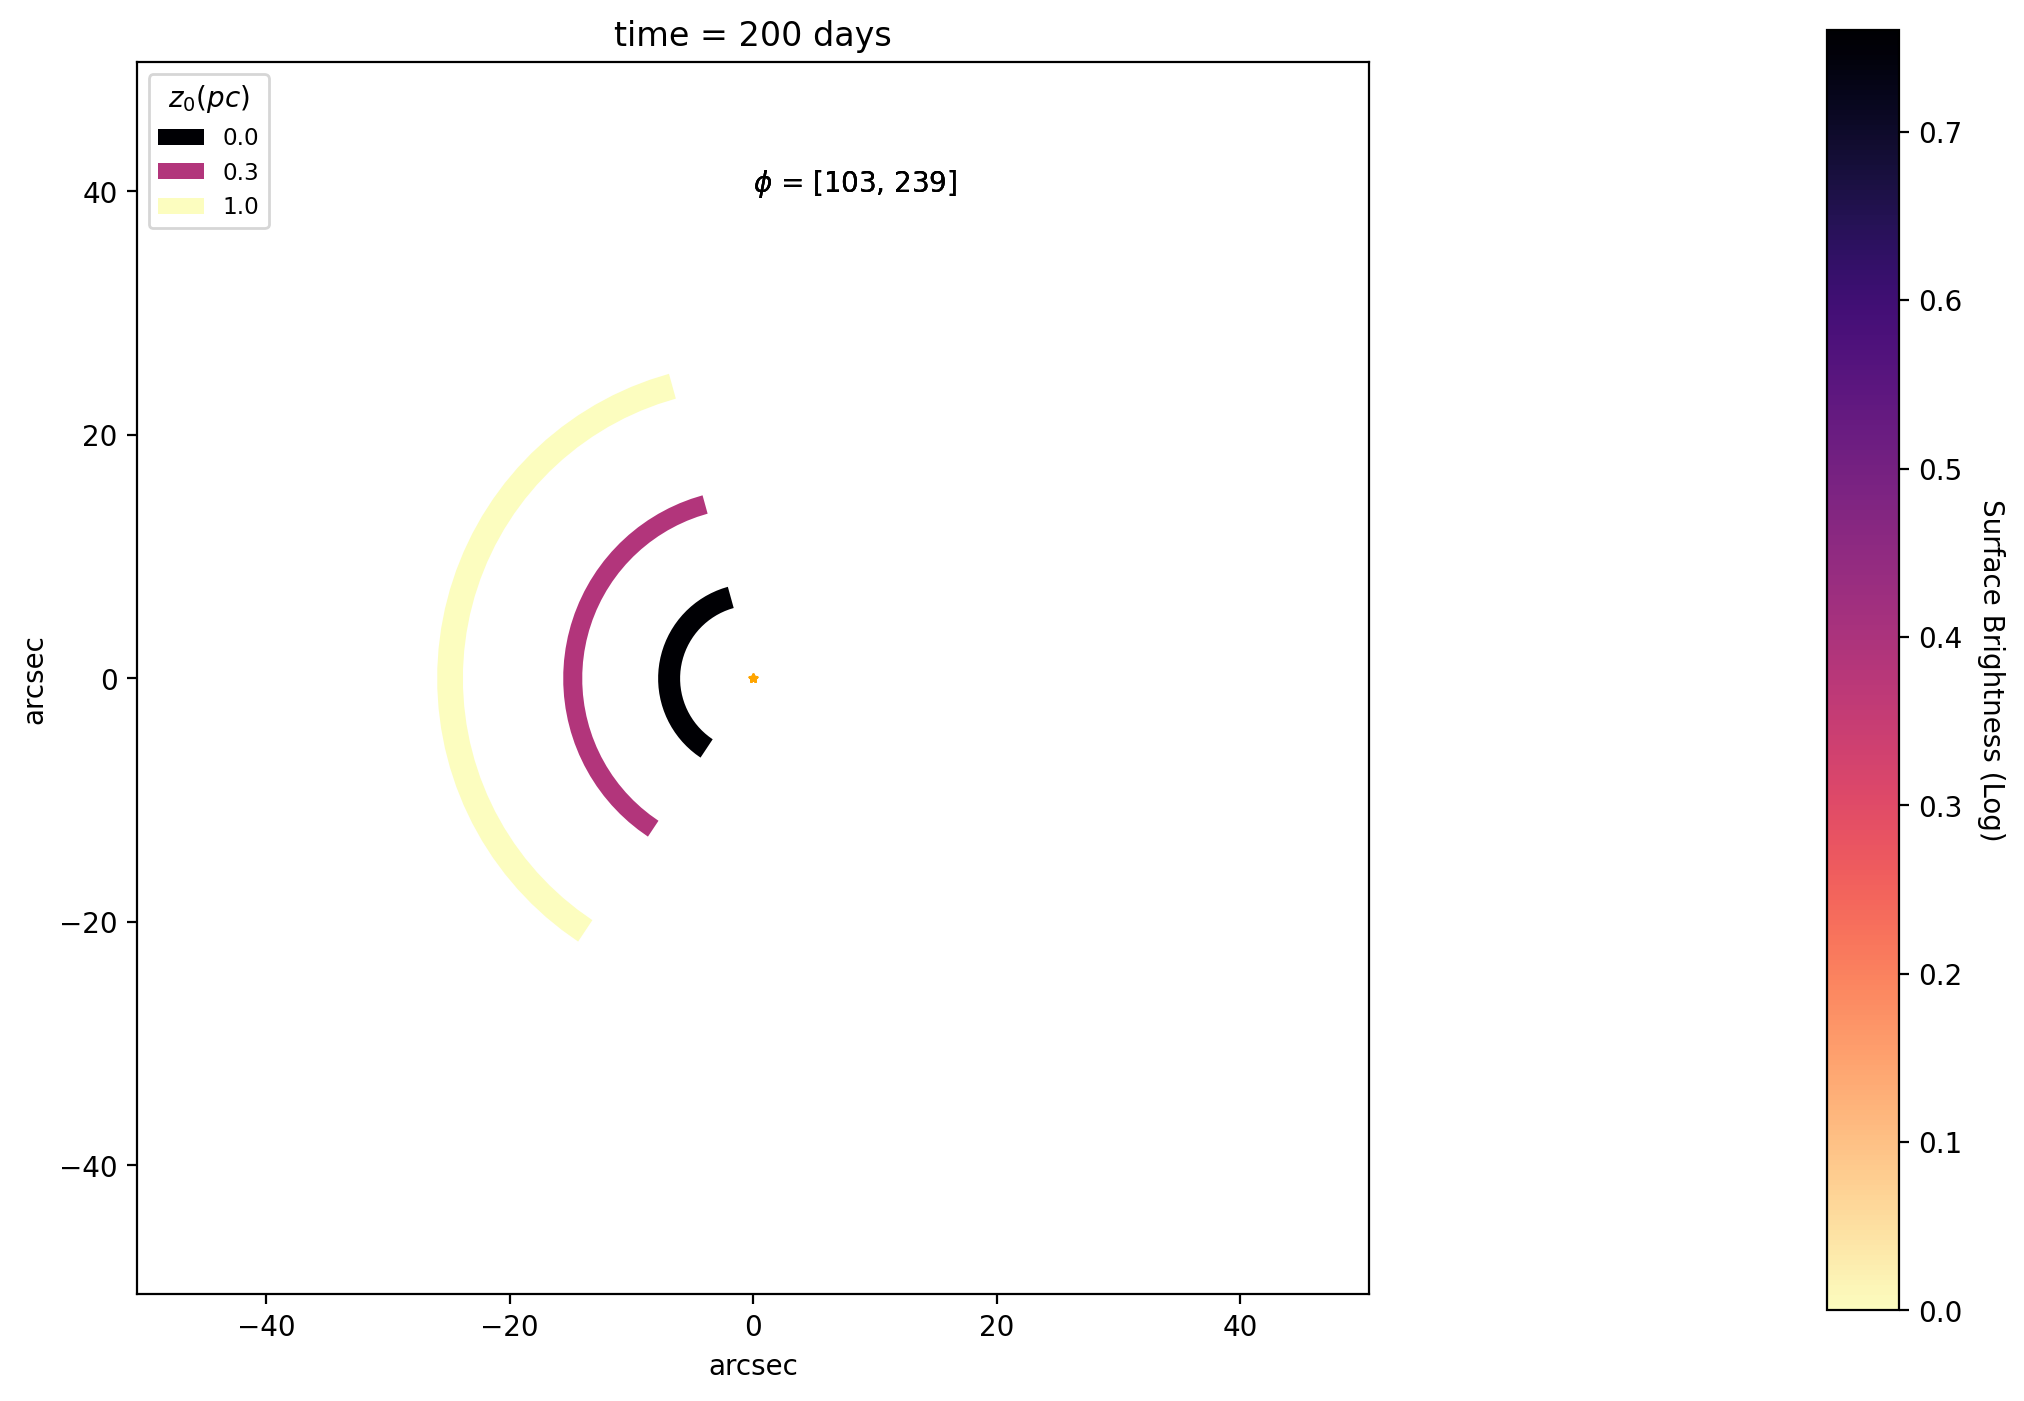

In [15]:
Deltat = [200] # days
dtoy = 0.00273973 # 1 day = 0.00273973 y
Deltat_y = np.array(Deltat) * dtoy
phi_min, phi_max = (104 / 180) * np.pi, (240 / 180) * np.pi
surface = surface_brightness_plane(Deltat_y, z0ly, dz0,  phi_min, phi_max)


angle = np.linspace(0, 2*np.pi, 100)
cmap = matplotlib.colormaps.get_cmap('magma_r')
nonzero = [np.mean(surface, axis=2) != 0]
surface_norm_nonzero = surface_norm[tuple(nonzero)]
normalize = matplotlib.colors.Normalize(vmin=surface_norm_nonzero.min(), vmax=surface_norm_nonzero.max())

XX = []
YY = []
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
for j, time in enumerate(Deltat_y):
  ct = time*c
  ax.set_title("time = %s days"%int(time/ dtoy))
  for i,z in enumerate(z0ly):
      if z < 0:
        # -- time ring star expanding
        ti = (-2 * z)/(c * (1 + a**2))
        # print(ti)
        if time >= ti:
          xs, ys = xy_plane_ring(angle, z, ct, dz0, dt0, a, d)
          XX.append(xs)
          YY.append(ys)
          plot_plane_dust(ax, d, xs, ys, z, surface_norm, surface, j, i)
          ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4)
        else:
          ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
      else:
        ti = dt0
        # -- for time less than the duration of the flash light, all the dust within the paraboiloid define for the dust and the source would be illuminated.
        if time <= ti:
          # -- rin and rout for the most inner ring keeps the same
          index = [k for k, x in enumerate(z0ly) if x >= 0]
          if i == index[0]:
            print(i, z0ly[i] / pctoly)
            xs, ys = xy_plane_ring(angle, z, ct, dz0, dt0, a, d)
            XX.append(xs)
            YY.append(ys)
            plot_plane_dust(ax, d, xs, ys, z, surface_norm, surface, j, i)
            ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
            ax.legend(loc='upper left', ncol=1, fontsize='small', title = r"$z_0 (pc)$")
          else:
            # -- for the rest of the rings, rin is rout of the previous ring
            r_le_out = r_outin(z, ct, dz0, dt0, a, "out")
            r_le_in = r_outin(z0ly[i-1], ct, dz0, dt0, a, "out")
            print(z / pctoly, z0ly[i-1] / pctoly, r_le_out, r_le_in)
            radii = [r_le_out, r_le_in]
            xs = np.outer(radii, np.cos(angle)) - a * ct
            ys = np.outer(radii, np.sin(angle))
            # in order to have a closed area, the circles
            # should be traversed in opposite directions
            xs[1,:] = xs[1,::-1]
            ys[1,:] = ys[1,::-1]
            XX.append(xs)
            YY.append(ys)
            plot_plane_dust(ax, d, xs, ys, z, surface_norm, surface, j, i)
            ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
            ax.legend(loc='upper left', ncol=1, fontsize='small', title = r"$z_0 (pc)$")
        elif time > ti:
          xs, ys = xy_plane_ring(angle, z, ct, dz0, dt0, a, d)
          XX.append(xs)
          YY.append(ys)
          plot_plane_dust(ax, d, xs, ys, z, surface_norm, surface, j, i)
          ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
          ax.legend(loc='upper left', ncol=1, fontsize='small', title = r"$z_0 (pc)$")

cbax = fig.add_axes([0.96, 0.1, 0.03, 0.80])

ax.set_xlabel("arcsec")
ax.set_ylabel("arcsec")
ax.set_box_aspect(1)

cb = matplotlib.colorbar.ColorbarBase(cbax, cmap=cmap, norm=normalize, orientation='vertical')
cb.set_label("Surface Brightness (Log)", rotation=270, labelpad=15)

def label_cbrt(x,pos):
    return "{:.1f}".format(x)

# cb.formatter = matplotlib.ticker.FuncFormatter(label_cbrt)
cb.update_ticks()
# plt.tight_layout()
# plt.savefig("figure2.png", dpi = 700, bbox_inches='tight')

plt.show()

# Add another pice in the picewise function for the density

In [16]:
def nh_phi_plus(params, phi_min = [0,0], phi_max = [2*np.pi,2*np.pi], n_h = n):
  """
    Define the density as a pairwise function that depends on the angle phi, the angle in the x,y sky plane
    Arguments
        params: list/array/tuple with the phi angle to be evaluate
        phi_min: min phi where the density value exist
        phi_max: min phi where the density value exist
        n_h: density value
    Return
        Value of the density with same shape as params
  """
  if ((phi_min[0] == 0) & (phi_max[0] == 2 * np.pi)):
    nh = n_h * np.ones(len(params))
    return nh

  else:
    nh = ((phi_min[0] <= params) & (params <= phi_max[0]))
    arr = np.array(nh, dtype=bool)
    int_arr = arr.astype(int)
    nh = int_arr * n_h

    nh2 = ((phi_min[1] <= params) & (params <= phi_max[1]))
    arr2 = np.array(nh2, dtype=bool)
    int_arr2 = arr2.astype(int)
    nh2 = int_arr2 * n_h * 0.004
  return nh, nh2

In [17]:
def surface_brightness_plane(Deltat_y, z0ly, dz0, phi_min, phi_max):
  """
    Arguments
        Deltat_y: time when the snap of the LE is taken by observer, in year
        z0ly: sitance of the dust in light-years
        dz0: thickness of the plane dust
        phi_min: inferior limit where the dust is located in the sky plane
        phi_max: superior limit where the dust is located in the sky plane
  """

  phi = np.linspace(0, 2*np.pi, 100)
  Nd = np.array([nh_phi_plus(phi, [phi_min[0], phi_min[1]], [phi_max[0], phi_max[1]])]).reshape(2, 100)
  # print(len(Nd), Nd.shape)
  surface = np.zeros((len(Deltat_y), len(z0ly), len(Nd), 100))
  for j, time in enumerate(Deltat_y):
    ct = time * c
    for i, z in enumerate(z0ly):
      if z < 0:
        # print(z)
        ti = (-2 * z)/(c * (1 + a**2))
        # print(ti)
        if time >= ti:
          # print(z)
          r_le = np.sqrt(2 * z * ct + (ct)**2 * (1 + a**2) )
          # print(r_le)
          x = r_le * np.cos(phi) - a * ct
          # -- distance source - dust
          r = z - a * x + ct
          # -- rho = x^2 + y^2 = r_le
          rhodrho  = 0.5 * (dz0 - a * x + c * dt0)
          # print(len(x), len(theta))
          surface[j, i, :, :] = Ir * Nd * dz0 / ( 4 * np.pi * r * rhodrho)
        elif time < ti:
          surface[j, i, :, :] = Ir * Nd * np.zeros(len(phi))
      elif z >= 0:
        ti = 0
        if time >= 0:
          r_le = np.sqrt(2 * z * ct + (ct)**2 * (1 + a**2))
          # print((ct / c) / dtoy)
          x = r_le * np.cos(phi) - a * ct
          # print(x)
          # -- distance source - dust
          r = z - a * x + ct
          # print(r)
          # -- rho = x^2 + y^2 = r_le
          rhodrho  = 0.5 * (dz0 - a * x + c * dt0)
          # print(rhodrho)
          surface[j, i, :, :] = Ir * Nd * dz0 / ( 4 * np.pi * r * rhodrho)
          # print(j, i, surface[j, i, :])

  # mean = []
  print(surface.shape)
  means = np.mean(surface, axis = (3))
  mean = np.log(means, where = 0 < means, out = np.nan * means)
  print(mean)

  surface_norm = (mean - np.nanmin(mean)) / (np.nanmax(mean) - np.nanmin(mean))
  surface_norm = np.array(surface_norm).reshape(len(Deltat),len(z0ly),2)

  return surface, surface_norm


In [18]:
def plot_plane_dust(ax, d, xs, ys, z, phi_min, phi_max, surface_norm, surface, j, i, k):
    ax.set_xlim(np.arctan(-4/d) * (180 / np.pi) * 3600 , np.arctan(4/d) * (180 / np.pi) * 3600)
    ax.set_ylim(np.arctan(-4/d) * (180 / np.pi) * 3600 , np.arctan(4/d) * (180 / np.pi) * 3600)
    # ax.fill(np.ravel(xs), np.ravel(ys), lw=0, color=cmap(normalize(surface_norm[j,i])), alpha = 0.3)
    xxx = xs.copy()
    yyy = ys.copy()
    xxx[1,:] = xxx[1,::-1]
    yyy[1,:] = yyy[1,::-1]
    new_xs = xxx.copy()[:,(surface[j,i,k,:] > 0)]
    new_xs[1,:] = new_xs[1,::-1]
    new_ys = yyy.copy()[:,(surface[j,i,k,:] > 0)]
    new_ys[1,:] = new_ys[1,::-1]
    ax.fill(np.ravel(new_xs), np.ravel(new_ys), lw=0, color=cmap(normalize(surface_norm[j,i,k])), label="%s"%(z/pctoly))
    ax.text( 20,-45, r"$\phi$ = [%s, %s]"%(  int((phi_min[0] * 180) / np.pi), int((phi_max[0] * 180) / np.pi)))
    ax.text(-20,-45, r"$\phi$ = [%s, %s]"%(  int((phi_min[1] * 180) / np.pi), int((phi_max[1] * 180) / np.pi)))

    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4)

    return ax

(1, 4, 2, 100)
[[[38.20427763 33.56520589]
  [37.69873377 33.05966203]
  [36.9146187  32.27554696]
  [36.09567102 31.45659928]]]


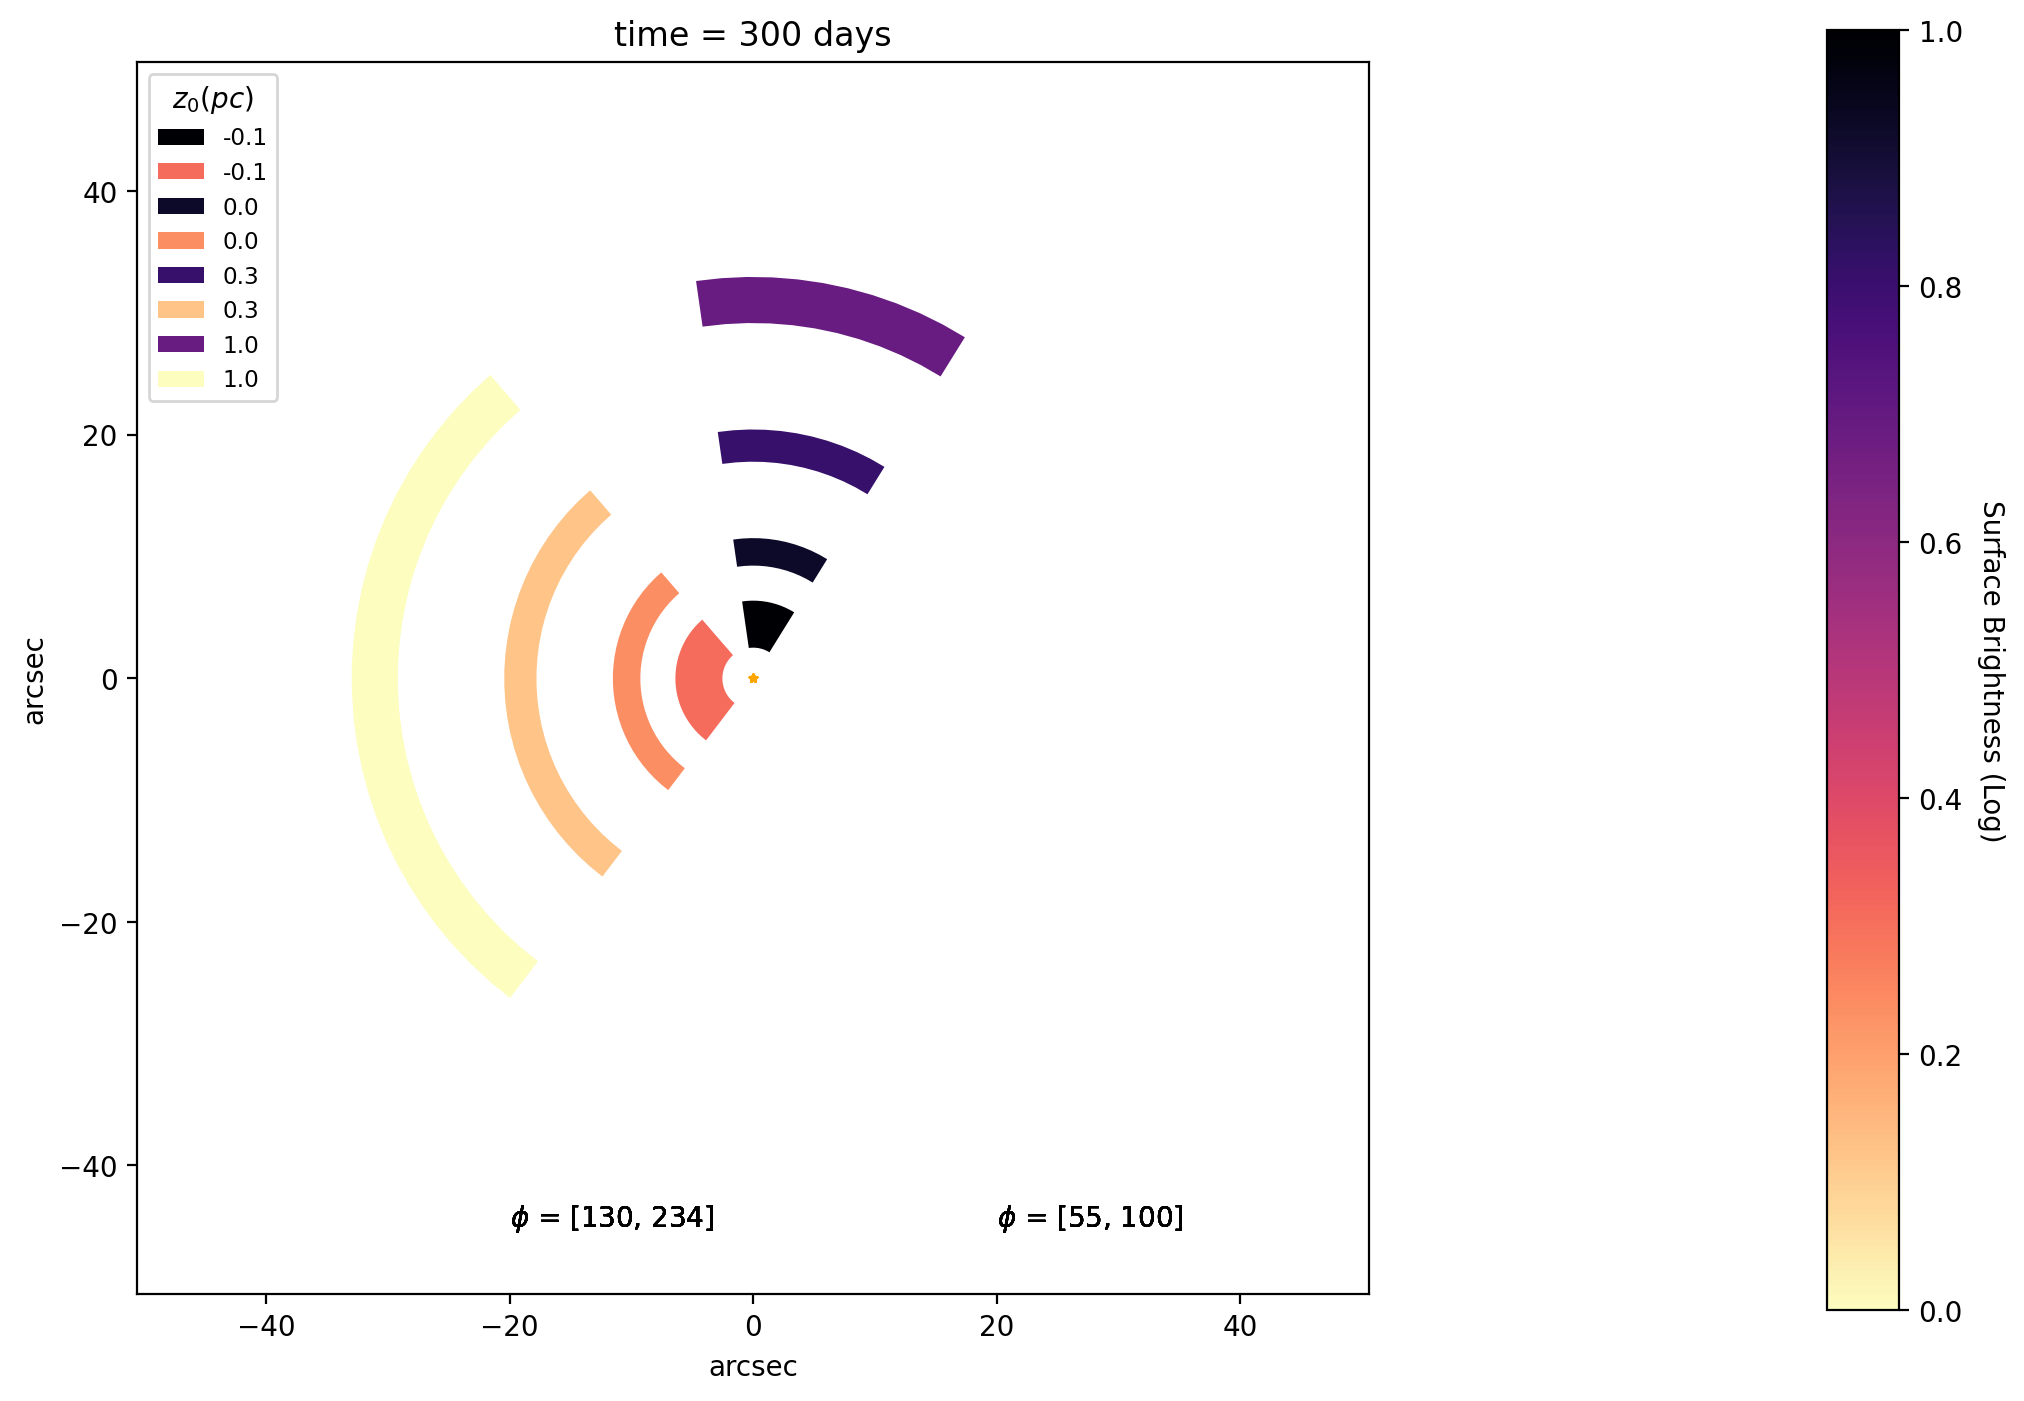

In [19]:
Deltat = [300] # days
dtoy = 0.00273973 # 1 day = 0.00273973 y
Deltat_y = np.array(Deltat) * dtoy

phi_min, phi_max = (55 / 180) * np.pi, (100 / 180) * np.pi
phi_min2, phi_max2 = (130 / 180) * np.pi, (234 / 180) * np.pi

surface, surface_norm = surface_brightness_plane(Deltat_y, z0ly, dz0, [phi_min, phi_min2], [phi_max, phi_max2])
# phi_min, phi_max = (104 / 180) * np.pi, (240 / 180) * np.pi
# surface = surface_brightness_plane(Deltat_y, z0ly, dz0,  phi_min, phi_max)


angle = np.linspace(0, 2*np.pi, 100)
cmap = matplotlib.colormaps.get_cmap('magma_r')
# nonzero = [np.mean(surface, axis=2) != 0]
# surface_norm_nonzero = surface_norm[tuple(nonzero)]
normalize = matplotlib.colors.Normalize(vmin=np.nanmin(surface_norm), vmax=np.nanmax(surface_norm))

XX = []
YY = []
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
for j, time in enumerate(Deltat_y):
  ct = time*c
  ax.set_title("time = %s days"%int(time/ dtoy))
  for i,z in enumerate(z0ly):
    for k in range(2):
        if z < 0:
          # -- time ring star expanding
          ti = (-2 * z)/(c * (1 + a**2))
          # print(ti)
          if time >= ti:
            xs, ys = xy_plane_ring(angle, z, ct, dz0, dt0, a, d)
            XX.append(xs)
            YY.append(ys)
            plot_plane_dust(ax, d, xs, ys, z, [phi_min, phi_min2], [phi_max, phi_max2], surface_norm, surface, j, i, k)
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4)
          else:
            ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
        else:
          ti = dt0
          # -- for time less than the duration of the flash light, all the dust within the paraboiloid define for the dust and the source would be illuminated.
          if time <= ti:
            # -- rin and rout for the most inner ring keeps the same
            index = [k for k, x in enumerate(z0ly) if x >= 0]
            if i == index[0]:
              print(i, z0ly[i] / pctoly)
              xs, ys = xy_plane_ring(angle, z, ct, dz0, dt0, a, d)
              XX.append(xs)
              YY.append(ys)
              plot_plane_dust(ax, d, xs, ys, z, [phi_min, phi_min2], [phi_max, phi_max2], surface_norm, surface, j, i, k)
              ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
              ax.legend(loc='upper left', ncol=1, fontsize='small', title = r"$z_0 (pc)$")
            else:
              # -- for the rest of the rings, rin is rout of the previous ring
              r_le_out = r_outin(z, ct, dz0, dt0, a, "out")
              r_le_in = r_outin(z0ly[i-1], ct, dz0, dt0, a, "out")
              print(z / pctoly, z0ly[i-1] / pctoly, r_le_out, r_le_in)
              radii = [r_le_out, r_le_in]
              xs = np.outer(radii, np.cos(angle)) - a * ct
              ys = np.outer(radii, np.sin(angle))
              # in order to have a closed area, the circles
              # should be traversed in opposite directions
              xs[1,:] = xs[1,::-1]
              ys[1,:] = ys[1,::-1]
              XX.append(xs)
              YY.append(ys)
              plot_plane_dust(ax, d, xs, ys, z, [phi_min, phi_min2], [phi_max, phi_max2], surface_norm, surface, j, i, k)
              ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
              ax.legend(loc='upper left', ncol=1, fontsize='small', title = r"$z_0 (pc)$")
          elif time > ti:
            xs, ys = xy_plane_ring(angle, z, ct, dz0, dt0, a, d)
            XX.append(xs)
            YY.append(ys)
            plot_plane_dust(ax, d, xs, ys, z, [phi_min, phi_min2], [phi_max, phi_max2], surface_norm, surface, j, i, k)
            ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
            ax.legend(loc='upper left', ncol=1, fontsize='small', title = r"$z_0 (pc)$")

cbax = fig.add_axes([0.96, 0.1, 0.03, 0.80])

ax.set_xlabel("arcsec")
ax.set_ylabel("arcsec")
ax.set_box_aspect(1)

cb = matplotlib.colorbar.ColorbarBase(cbax, cmap=cmap, norm=normalize, orientation='vertical')
cb.set_label("Surface Brightness (Log)", rotation=270, labelpad=15)

def label_cbrt(x,pos):
    return "{:.1f}".format(x)

# cb.formatter = matplotlib.ticker.FuncFormatter(label_cbrt)
cb.update_ticks()
# plt.tight_layout()
# plt.savefig("figure2.png", dpi = 700, bbox_inches='tight')

plt.show()

(1, 4, 2, 100)
[[[37.45983963 32.82076789]
  [37.18790815 32.54883641]
  [36.64891463 32.00984289]
  [35.96975575 31.33068401]]]


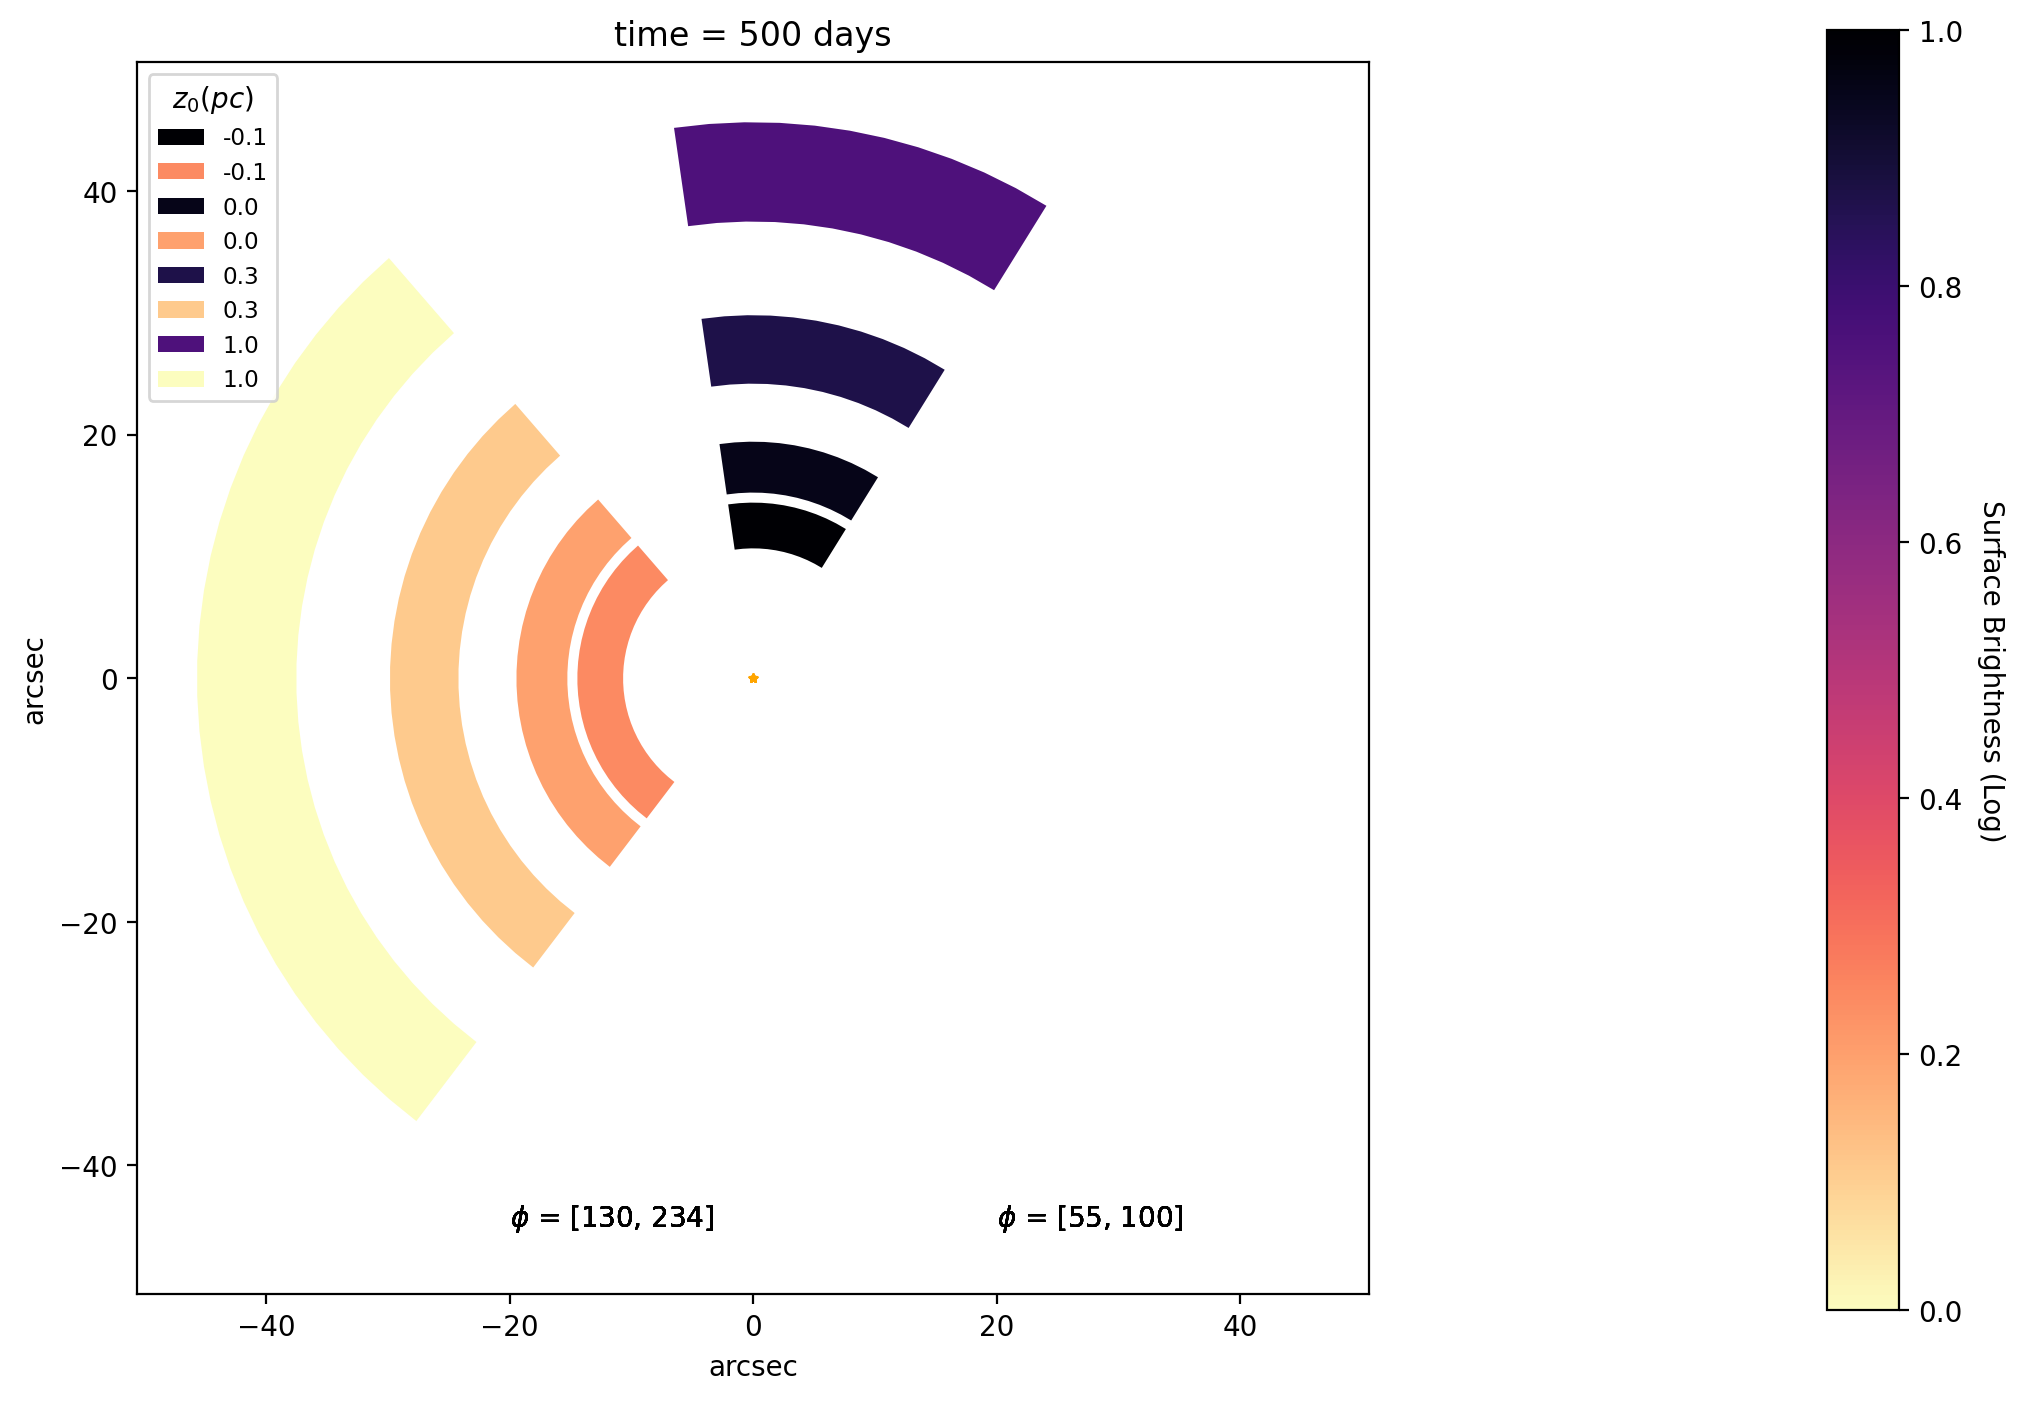

In [20]:
Deltat = [300+200] # days
dtoy = 0.00273973 # 1 day = 0.00273973 y
Deltat_y = np.array(Deltat) * dtoy

phi_min, phi_max = (55 / 180) * np.pi, (100 / 180) * np.pi
phi_min2, phi_max2 = (130 / 180) * np.pi, (234 / 180) * np.pi

surface, surface_norm = surface_brightness_plane(Deltat_y, z0ly, dz0, [phi_min, phi_min2], [phi_max, phi_max2])
# phi_min, phi_max = (104 / 180) * np.pi, (240 / 180) * np.pi
# surface = surface_brightness_plane(Deltat_y, z0ly, dz0,  phi_min, phi_max)


angle = np.linspace(0, 2*np.pi, 100)
cmap = matplotlib.colormaps.get_cmap('magma_r')
# nonzero = [np.mean(surface, axis=2) != 0]
# surface_norm_nonzero = surface_norm[tuple(nonzero)]
normalize = matplotlib.colors.Normalize(vmin=np.nanmin(surface_norm), vmax=np.nanmax(surface_norm))

XX = []
YY = []
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
for j, time in enumerate(Deltat_y):
  ct = time*c
  ax.set_title("time = %s days"%int(time/ dtoy))
  for i,z in enumerate(z0ly):
    for k in range(2):
        if z < 0:
          # -- time ring star expanding
          ti = (-2 * z)/(c * (1 + a**2))
          # print(ti)
          if time >= ti:
            xs, ys = xy_plane_ring(angle, z, ct, dz0, dt0, a, d)
            XX.append(xs)
            YY.append(ys)
            plot_plane_dust(ax, d, xs, ys, z, [phi_min, phi_min2], [phi_max, phi_max2], surface_norm, surface, j, i, k)
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4)
          else:
            ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
        else:
          ti = dt0
          # -- for time less than the duration of the flash light, all the dust within the paraboiloid define for the dust and the source would be illuminated.
          if time <= ti:
            # -- rin and rout for the most inner ring keeps the same
            index = [k for k, x in enumerate(z0ly) if x >= 0]
            if i == index[0]:
              print(i, z0ly[i] / pctoly)
              xs, ys = xy_plane_ring(angle, z, ct, dz0, dt0, a, d)
              XX.append(xs)
              YY.append(ys)
              plot_plane_dust(ax, d, xs, ys, z, [phi_min, phi_min2], [phi_max, phi_max2], surface_norm, surface, j, i, k)
              ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
              ax.legend(loc='upper left', ncol=1, fontsize='small', title = r"$z_0 (pc)$")
            else:
              # -- for the rest of the rings, rin is rout of the previous ring
              r_le_out = r_outin(z, ct, dz0, dt0, a, "out")
              r_le_in = r_outin(z0ly[i-1], ct, dz0, dt0, a, "out")
              print(z / pctoly, z0ly[i-1] / pctoly, r_le_out, r_le_in)
              radii = [r_le_out, r_le_in]
              xs = np.outer(radii, np.cos(angle)) - a * ct
              ys = np.outer(radii, np.sin(angle))
              # in order to have a closed area, the circles
              # should be traversed in opposite directions
              xs[1,:] = xs[1,::-1]
              ys[1,:] = ys[1,::-1]
              XX.append(xs)
              YY.append(ys)
              plot_plane_dust(ax, d, xs, ys, z, [phi_min, phi_min2], [phi_max, phi_max2], surface_norm, surface, j, i, k)
              ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
              ax.legend(loc='upper left', ncol=1, fontsize='small', title = r"$z_0 (pc)$")
          elif time > ti:
            xs, ys = xy_plane_ring(angle, z, ct, dz0, dt0, a, d)
            XX.append(xs)
            YY.append(ys)
            plot_plane_dust(ax, d, xs, ys, z, [phi_min, phi_min2], [phi_max, phi_max2], surface_norm, surface, j, i, k)
            ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
            ax.legend(loc='upper left', ncol=1, fontsize='small', title = r"$z_0 (pc)$")

cbax = fig.add_axes([0.96, 0.1, 0.03, 0.80])

ax.set_xlabel("arcsec")
ax.set_ylabel("arcsec")
ax.set_box_aspect(1)

cb = matplotlib.colorbar.ColorbarBase(cbax, cmap=cmap, norm=normalize, orientation='vertical')
cb.set_label("Surface Brightness (Log)", rotation=270, labelpad=15)

def label_cbrt(x,pos):
    return "{:.1f}".format(x)

# cb.formatter = matplotlib.ticker.FuncFormatter(label_cbrt)
cb.update_ticks()
# plt.tight_layout()
# plt.savefig("figure2.png", dpi = 700, bbox_inches='tight')

plt.show()

# Density picewise with two condition, one of them a power law

In [21]:
def nh_phi_plus_power(params, phi_min = [0,0], phi_max = [2*np.pi,2*np.pi], k = 1, n_h = n):
  """
    Define the density as a pairwise function that depends on the angle phi, the angle in the x,y sky plane
    Arguments
        params: list/array/tuple with the phi angle to be evaluate
        phi_min: min phi where the density value exist
        phi_max: min phi where the density value exist
        n_h: density value
    Return
        Value of the density with same shape as params
  """
  if ((phi_min[0] == 0) & (phi_max[0] == 2 * np.pi)):
    nh = n_h * np.ones(len(params))
    return nh

  else:
    nh = ((phi_min[0] <= params) & (params <= phi_max[0]))
    arr = np.array(nh, dtype=bool)
    int_arr = arr.astype(int)
    nh = int_arr * n_h

    nh2 = ((phi_min[1] <= params) & (params <= phi_max[1]))
    arr2 = np.array(nh2, dtype=bool)
    int_arr2 = arr2.astype(int)
    nh2 = int_arr2 * n_h ** k
  return nh, nh2

In [22]:
def surface_brightness_plane(Deltat_y, z0ly, dz0, Nd):
  """
    Arguments
        Deltat_y: time when the snap of the LE is taken by observer, in year
        z0ly: sitance of the dust in light-years
        dz0: thickness of the plane dust
        Nd: density
  """

  # phi = np.linspace(0, 2*np.pi, 100)
  # Nd = np.array([nh_phi_plus_power(phi, [phi_min[0], phi_min[1]], [phi_max[0], phi_max[1]], k = -2)]).reshape(2, 100)
  # print(len(Nd), Nd.shape)
  surface = np.zeros((len(Deltat_y), len(z0ly), len(Nd), 100))
  for j, time in enumerate(Deltat_y):
    ct = time * c
    for i, z in enumerate(z0ly):
      if z < 0:
        # print(z)
        ti = (-2 * z)/(c * (1 + a**2))
        # print(ti)
        if time >= ti:
          # print(z)
          r_le = np.sqrt(2 * z * ct + (ct)**2 * (1 + a**2) )
          # print(r_le)
          x = r_le * np.cos(phi) - a * ct
          # -- distance source - dust
          r = z - a * x + ct
          # -- rho = x^2 + y^2 = r_le
          rhodrho  = 0.5 * (dz0 - a * x + c * dt0)
          # print(len(x), len(theta))
          surface[j, i, :, :] = Ir * Nd * dz0 / ( 4 * np.pi * r * rhodrho)
        elif time < ti:
          surface[j, i, :, :] = Ir * Nd * np.zeros(len(phi))
      elif z >= 0:
        ti = 0
        if time >= 0:
          r_le = np.sqrt(2 * z * ct + (ct)**2 * (1 + a**2))
          # print((ct / c) / dtoy)
          x = r_le * np.cos(phi) - a * ct
          # print(x)
          # -- distance source - dust
          r = z - a * x + ct
          # print(r)
          # -- rho = x^2 + y^2 = r_le
          rhodrho  = 0.5 * (dz0 - a * x + c * dt0)
          # print(rhodrho)
          surface[j, i, :, :] = Ir * Nd * dz0 / ( 4 * np.pi * r * rhodrho)
          # print(j, i, surface[j, i, :])

  # mean = []
  print(surface.shape)
  means = np.percentile(surface, 99, axis=3)
  mean = np.log(means, where = 0 < means, out = np.nan * means)
  print(mean)

  surface_norm = (mean - np.nanmin(mean)) / (np.nanmax(mean) - np.nanmin(mean))
  surface_norm = np.array(surface_norm).reshape(len(Deltat),len(z0ly), 2)

  return surface, surface_norm


(1, 4, 2, 100)
[[[        nan         nan]
  [40.9176096  53.41826105]
  [39.39778943 51.89844089]
  [38.36001981 50.86067127]]]


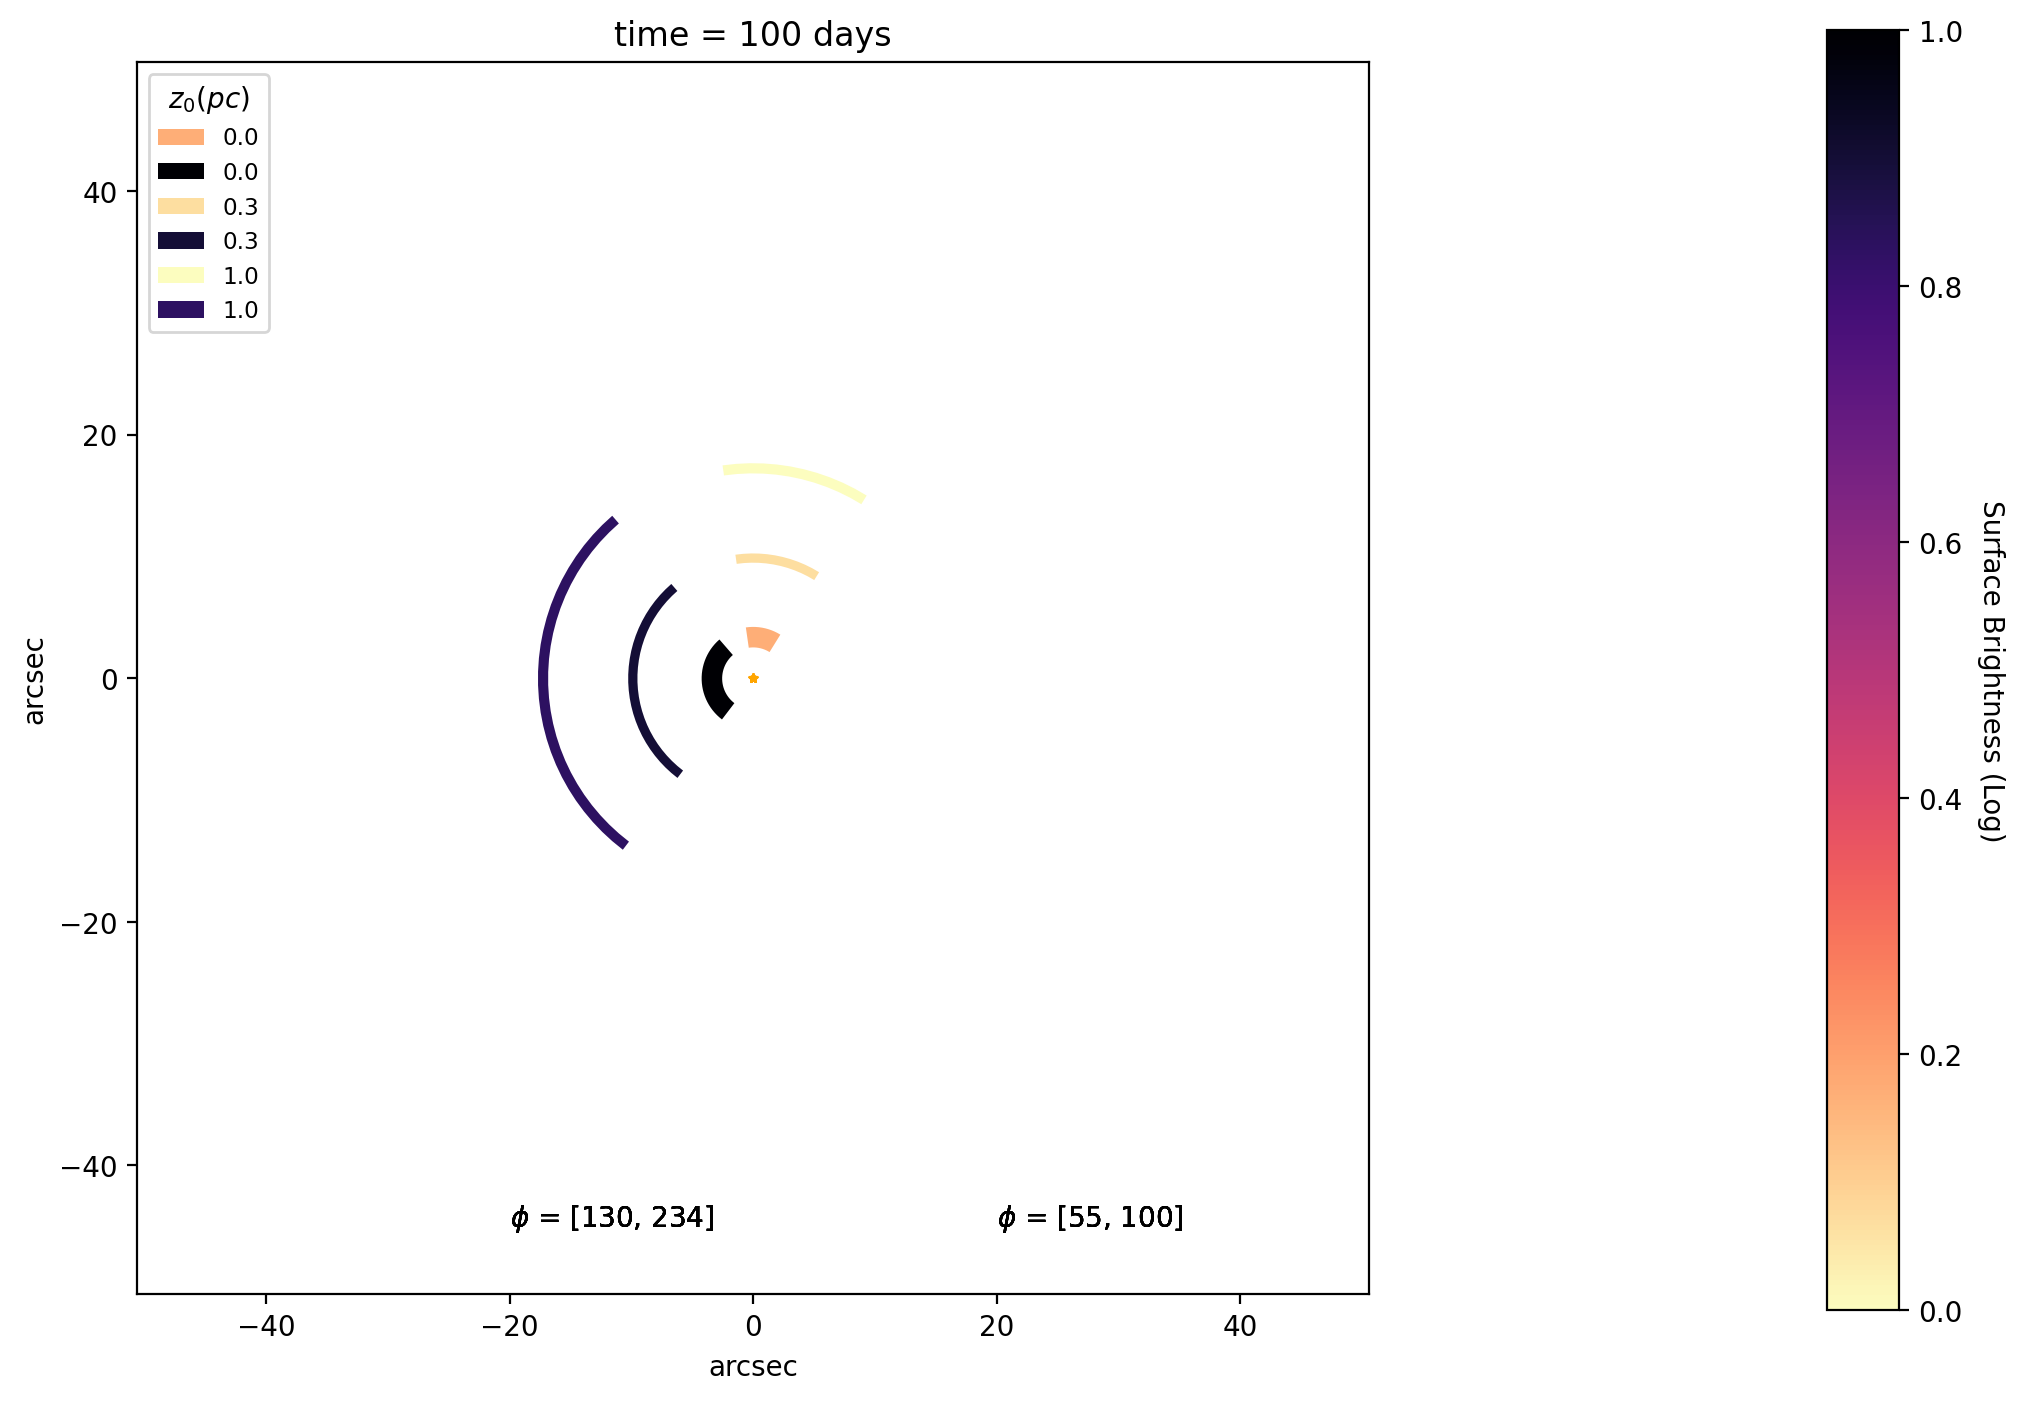

In [23]:
Deltat = [100] # days
dtoy = 0.00273973 # 1 day = 0.00273973 y
Deltat_y = np.array(Deltat) * dtoy

phi_min, phi_max = (55 / 180) * np.pi, (100 / 180) * np.pi
phi_min2, phi_max2 = (130 / 180) * np.pi, (234 / 180) * np.pi

phi = np.linspace(0, 2*np.pi, 100)
Nd = np.array([nh_phi_plus_power(phi, [phi_min, phi_min2], [phi_max, phi_max2], k = 1.1)]).reshape(2, 100)

surface, surface_norm = surface_brightness_plane(Deltat_y, z0ly, dz0, Nd)
# phi_min, phi_max = (104 / 180) * np.pi, (240 / 180) * np.pi
# surface = surface_brightness_plane(Deltat_y, z0ly, dz0,  phi_min, phi_max)


angle = phi.copy()
cmap = matplotlib.colormaps.get_cmap('magma_r')
# nonzero = [np.mean(surface, axis=2) != 0]
# surface_norm_nonzero = surface_norm[tuple(nonzero)]
normalize = matplotlib.colors.Normalize(vmin=np.nanmin(surface_norm), vmax=np.nanmax(surface_norm))

XX = []
YY = []
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
for j, time in enumerate(Deltat_y):
  ct = time*c
  ax.set_title("time = %s days"%int(time/ dtoy))
  for i,z in enumerate(z0ly):
    for k in range(2):
        if z < 0:
          # -- time ring star expanding
          ti = (-2 * z)/(c * (1 + a**2))
          # print(ti)
          if time >= ti:
            xs, ys = xy_plane_ring(angle, z, ct, dz0, dt0, a, d)
            XX.append(xs)
            YY.append(ys)
            plot_plane_dust(ax, d, xs, ys, z, [phi_min, phi_min2], [phi_max, phi_max2], surface_norm, surface, j, i, k)
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4)
          else:
            ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
        else:
          ti = dt0
          # -- for time less than the duration of the flash light, all the dust within the paraboiloid define for the dust and the source would be illuminated.
          if time <= ti:
            # -- rin and rout for the most inner ring keeps the same
            index = [k for k, x in enumerate(z0ly) if x >= 0]
            if i == index[0]:
              print(i, z0ly[i] / pctoly)
              xs, ys = xy_plane_ring(angle, z, ct, dz0, dt0, a, d)
              XX.append(xs)
              YY.append(ys)
              plot_plane_dust(ax, d, xs, ys, z, [phi_min, phi_min2], [phi_max, phi_max2], surface_norm, surface, j, i, k)
              ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
              ax.legend(loc='upper left', ncol=1, fontsize='small', title = r"$z_0 (pc)$")
            else:
              # -- for the rest of the rings, rin is rout of the previous ring
              r_le_out = r_outin(z, ct, dz0, dt0, a, "out")
              r_le_in = r_outin(z0ly[i-1], ct, dz0, dt0, a, "out")
              print(z / pctoly, z0ly[i-1] / pctoly, r_le_out, r_le_in)
              radii = [r_le_out, r_le_in]
              xs = np.outer(radii, np.cos(angle)) - a * ct
              ys = np.outer(radii, np.sin(angle))
              # in order to have a closed area, the circles
              # should be traversed in opposite directions
              xs[1,:] = xs[1,::-1]
              ys[1,:] = ys[1,::-1]
              XX.append(xs)
              YY.append(ys)
              plot_plane_dust(ax, d, xs, ys, z, [phi_min, phi_min2], [phi_max, phi_max2], surface_norm, surface, j, i, k)
              ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
              ax.legend(loc='upper left', ncol=1, fontsize='small', title = r"$z_0 (pc)$")
          elif time > ti:
            xs, ys = xy_plane_ring(angle, z, ct, dz0, dt0, a, d)
            XX.append(xs)
            YY.append(ys)
            plot_plane_dust(ax, d, xs, ys, z, [phi_min, phi_min2], [phi_max, phi_max2], surface_norm, surface, j, i, k)
            ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
            ax.legend(loc='upper left', ncol=1, fontsize='small', title = r"$z_0 (pc)$")

cbax = fig.add_axes([0.96, 0.1, 0.03, 0.80])

ax.set_xlabel("arcsec")
ax.set_ylabel("arcsec")
ax.set_box_aspect(1)

cb = matplotlib.colorbar.ColorbarBase(cbax, cmap=cmap, norm=normalize, orientation='vertical')
cb.set_label("Surface Brightness (Log)", rotation=270, labelpad=15)

def label_cbrt(x,pos):
    return "{:.1f}".format(x)

# cb.formatter = matplotlib.ticker.FuncFormatter(label_cbrt)
cb.update_ticks()
# plt.tight_layout()
# plt.savefig("figure2.png", dpi = 700, bbox_inches='tight')

plt.show()

# Density = nH * func(phi) ** k

## func = int, float or a function

In [24]:
def nh_phi_plus_power(params, k = 1, n_h = n):
  """
    Define the density as a pairwise function that depends on the angle phi, the angle in the x,y sky plane
    Arguments
        params: list/array/tuple with the phi angle to be evaluate
        phi_min: min phi where the density value exist
        phi_max: min phi where the density value exist
        n_h: density value
    Return
        Value of the density with same shape as params
  """

  nh = n_h * params ** k
  nh = np.nan_to_num(nh, nan = 0)
  return nh

In [25]:
def surface_brightness_plane(Deltat_y, z0ly, dz0, Nd, phi):
  """
    Arguments
        Deltat_y: time when the snap of the LE is taken by observer, in year
        z0ly: sitance of the dust in light-years
        dz0: thickness of the plane dust
        Nd: density
  """

  # phi = np.linspace(0, 2*np.pi, 100)
  # Nd = np.array([nh_phi_plus_power(phi, [phi_min[0], phi_min[1]], [phi_max[0], phi_max[1]], k = -2)]).reshape(2, 100)
  # print(len(Nd), Nd.shape)
  surface = np.zeros((len(Deltat_y), len(z0ly), len(phi)))
  print(surface.shape)
  for j, time in enumerate(Deltat_y):
    ct = time * c
    for i, z in enumerate(z0ly):
      if z < 0:
        # print(z)
        ti = (-2 * z)/(c * (1 + a**2))
        # print(ti)
        if time >= ti:
          # print(z)
          r_le = np.sqrt(2 * z * ct + (ct)**2 * (1 + a**2) )
          # print(r_le)
          x = r_le * np.cos(phi) - a * ct
          # -- distance source - dust
          r = z - a * x + ct
          # -- rho = x^2 + y^2 = r_le
          rhodrho  = 0.5 * (dz0 - a * x + c * dt0)
          # print(len(x), len(theta))
          surface[j, i, :] = Ir * Nd * dz0 / ( 4 * np.pi * r * rhodrho)
        elif time < ti:
          surface[j, i, :] = Ir * Nd * np.zeros(len(phi))
      elif z >= 0:
        ti = 0
        if time >= 0:
          r_le = np.sqrt(2 * z * ct + (ct)**2 * (1 + a**2))
          # print((ct / c) / dtoy)
          x = r_le * np.cos(phi) - a * ct
          # print(x)
          # -- distance source - dust
          r = z - a * x + ct
          # print(r)
          # -- rho = x^2 + y^2 = r_le
          rhodrho  = 0.5 * (dz0 - a * x + c * dt0)
          # print(rhodrho)
          surface[j, i, :] = Ir * Nd * dz0 / ( 4 * np.pi * r * rhodrho)
          # print(j, i, surface[j, i, :])


  surface = surface.reshape(len(Deltat), len(z0ly), max(Nd.shape))
  # print(surface.shape)

  # surface_norm = (mean - np.nanmin(mean)) / (np.nanmax(mean) - np.nanmin(mean))
  # surface_norm = np.array(surface_norm).reshape(len(Deltat),len(z0ly), max(Nd.shape))

  return surface


In [26]:
def plot_plane_dust(ax, d, xs, ys, z, surface, j, i, k):

    cmap = matplotlib.colormaps.get_cmap('Greys')
    normalize = matplotlib.colors.Normalize(vmin=np.nanmin(surface), vmax=np.nanmax(surface))
    ax.set_xlim(np.arctan(-4/d) * (180 / np.pi) * 3600 , np.arctan(4/d) * (180 / np.pi) * 3600)
    ax.set_ylim(np.arctan(-4/d) * (180 / np.pi) * 3600 , np.arctan(4/d) * (180 / np.pi) * 3600)
    # ax.fill(np.ravel(xs), np.ravel(ys), lw=0, color=cmap(normalize(surface_norm[j,i])), alpha = 0.3)
    # print(xs.shape)
    xxx = xs.copy()
    yyy = ys.copy()
    xxx[1,:] = xxx[1,::-1]
    yyy[1,:] = yyy[1,::-1]
    new_xs = xxx.copy()
    # new_xs[1,:] = new_xs[1,::-1]
    new_ys = yyy.copy()
    # new_ys[1,:] = new_ys[1,::-1]
    # ax.scatter(new_xs[0][k], new_ys[0][k], s = 2, color=cmap(normalize(surface[j,i,k])))#, label="%s"%(surface[j, i, k]))
    # ax.scatter(new_xs[1][k], new_ys[1][k], s = 2, color=cmap(normalize(surface[j,i,k])))#, label="%s"%(surface[j, i, k]))
    ax.plot(new_xs[:, k], new_ys[:, k], marker = "None", color=cmap(normalize(surface[j,i,k])))#, label="%s"%(z/pctoly))
    # print(cmap(normalize(surface[j,i,k])))
    # ax.fill(np.ravel(new_xs[:,k]), np.ravel(new_ys[:,k]), lw=0, color=cmap(normalize(surface[j,i,k])), label="%s"%(z/pctoly))
    # ax.text( 20,-45, r"$\phi$ = [%s, %s]"%(  int((phi_min[0] * 180) / np.pi), int((phi_max[0] * 180) / np.pi)))
    # ax.text(-20,-45, r"$\phi$ = [%s, %s]"%(  int((phi_min[1] * 180) / np.pi), int((phi_max[1] * 180) / np.pi)))

    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4)

    return ax

In [27]:
def final_plot(delta_t, phi_min = 0, phi_max = 2 * np.pi, size_phi = 500, func = 1, k = 1):
  Deltat = [delta_t] # days
  Deltat_y = np.array(Deltat) * dtoy

  z0 = [-0.10, 0, 0.3, 1] # pc
  z0ly = np.array(z0) * pctoly

  # z0ly = [-0.10, 0.1, 0.3, 1]
  # z0ly = [0.1 * pctoly]


  phi = np.linspace(phi_min, phi_max, size_phi)
  print(phi.shape)
  if isinstance(func, (int, float)):
    Nd = np.array([nh_phi_plus_power(func * phi, k)]).reshape(1, len(phi))
  elif callable(func):
    Nd = np.array([nh_phi_plus_power(func(phi), k)]).reshape(1, len(phi))

  print(Nd.shape)
  surface = surface_brightness_plane(Deltat_y, z0ly, dz0, Nd, phi)
  surface = ( surface - np.nanmin(surface)  ) / (np.nanmax(surface) - np.nanmin(surface))
  # phi_min, phi_max = (104 / 180) * np.pi, (240 / 180) * np.pi
  # surface = surface_brightness_plane(Deltat_y, z0ly, dz0,  phi_min, phi_max)


  angle = phi.copy()
  cmap = matplotlib.colormaps.get_cmap('Greys')
  normalize = matplotlib.colors.Normalize(vmin=np.nanmin(surface), vmax=np.nanmax(surface))

  XX = []
  YY = []
  legend_dust = []
  fig, ax = plt.subplots(1, 1, figsize=(12, 8))
  for j, time in enumerate(Deltat_y):
    ct = time*c
    ax.set_title("time = %s days"%int(time/ dtoy))
    for i,z in enumerate(z0ly):
      for k in range(max(Nd.shape)):
          if z < 0:
            # -- time ring star expanding
            ti = (-2 * z)/(c * (1 + a**2))
            # print(ti)
            if time >= ti:
              xs, ys = xy_plane_ring(angle, z, ct, dz0, dt0, a, d)
              XX.append(xs)
              YY.append(ys)
              plot_plane_dust(ax, d, xs, ys, z, surface, j, i, k)
              legend_dust.append(z0ly[i] / pctoly)
              # ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4)
            else:
              ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
          else:
            ti = dt0
            # -- for time less than the duration of the flash light, all the dust within the paraboiloid define for the dust and the source would be illuminated.
            if time <= ti:
              # -- rin and rout for the most inner ring keeps the same
              index = [k for k, x in enumerate(z0ly) if x >= 0]
              if i == index[0]:
                print(i, z0ly[i] / pctoly)
                xs, ys = xy_plane_ring(angle, z, ct, dz0, dt0, a, d)
                XX.append(xs)
                YY.append(ys)
                plot_plane_dust(ax, d, xs, ys, z, surface, j, i, k)
                legend_dust.append(z0ly[i] / pctoly)
                ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
                # ax.legend(loc='upper left', ncol=1, fontsize='small', title = r"$z_0 (pc)$")
              else:
                # -- for the rest of the rings, rin is rout of the previous ring
                r_le_out = r_outin(z, ct, dz0, dt0, a, "out")
                r_le_in = r_outin(z0ly[i-1], ct, dz0, dt0, a, "out")
                print(z / pctoly, z0ly[i-1] / pctoly, r_le_out, r_le_in)
                radii = [r_le_out, r_le_in]
                xs = np.outer(radii, np.cos(angle)) - a * ct
                ys = np.outer(radii, np.sin(angle))
                # in order to have a closed area, the circles
                # should be traversed in opposite directions
                xs[1,:] = xs[1,::-1]
                ys[1,:] = ys[1,::-1]
                XX.append(xs)
                YY.append(ys)
                plot_plane_dust(ax, d, xs, ys, z, surface, j, i, k)
                ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
                # ax.legend(loc='upper left', ncol=1, fontsize='small', title = r"$z_0 (pc)$")
            elif time > ti:
              xs, ys = xy_plane_ring(angle, z, ct, dz0, dt0, a, d)
              XX.append(xs)
              YY.append(ys)
              plot_plane_dust(ax, d, xs, ys, z, surface, j, i, k)
              legend_dust.append(z0ly[i] / pctoly)
              ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
              # ax.legend(loc='upper left', ncol=1, fontsize='small', title = r"$z_0 (pc)$")
      ax.legend(set(legend_dust), loc='best',  ncol=4)

  cbax = fig.add_axes([0.96, 0.1, 0.03, 0.80])

  ax.set_xlabel("arcsec")
  ax.set_ylabel("arcsec")
  ax.set_box_aspect(1)

  cb = matplotlib.colorbar.ColorbarBase(cbax, cmap=cmap, norm=normalize, orientation='vertical')
  cb.set_label("Surface Brightness (Log)", rotation=270, labelpad=15)

  def label_cbrt(x,pos):
      return "{:.1f}".format(x)

  # cb.formatter = matplotlib.ticker.FuncFormatter(label_cbrt)
  cb.update_ticks()
  # plt.tight_layout()
  # plt.savefig("figure2.png", dpi = 700, bbox_inches='tight')
  # print(set(legend_dust))
  plt.show()

  return surface, Nd

(500,)
(1, 500)
(1, 4, 500)


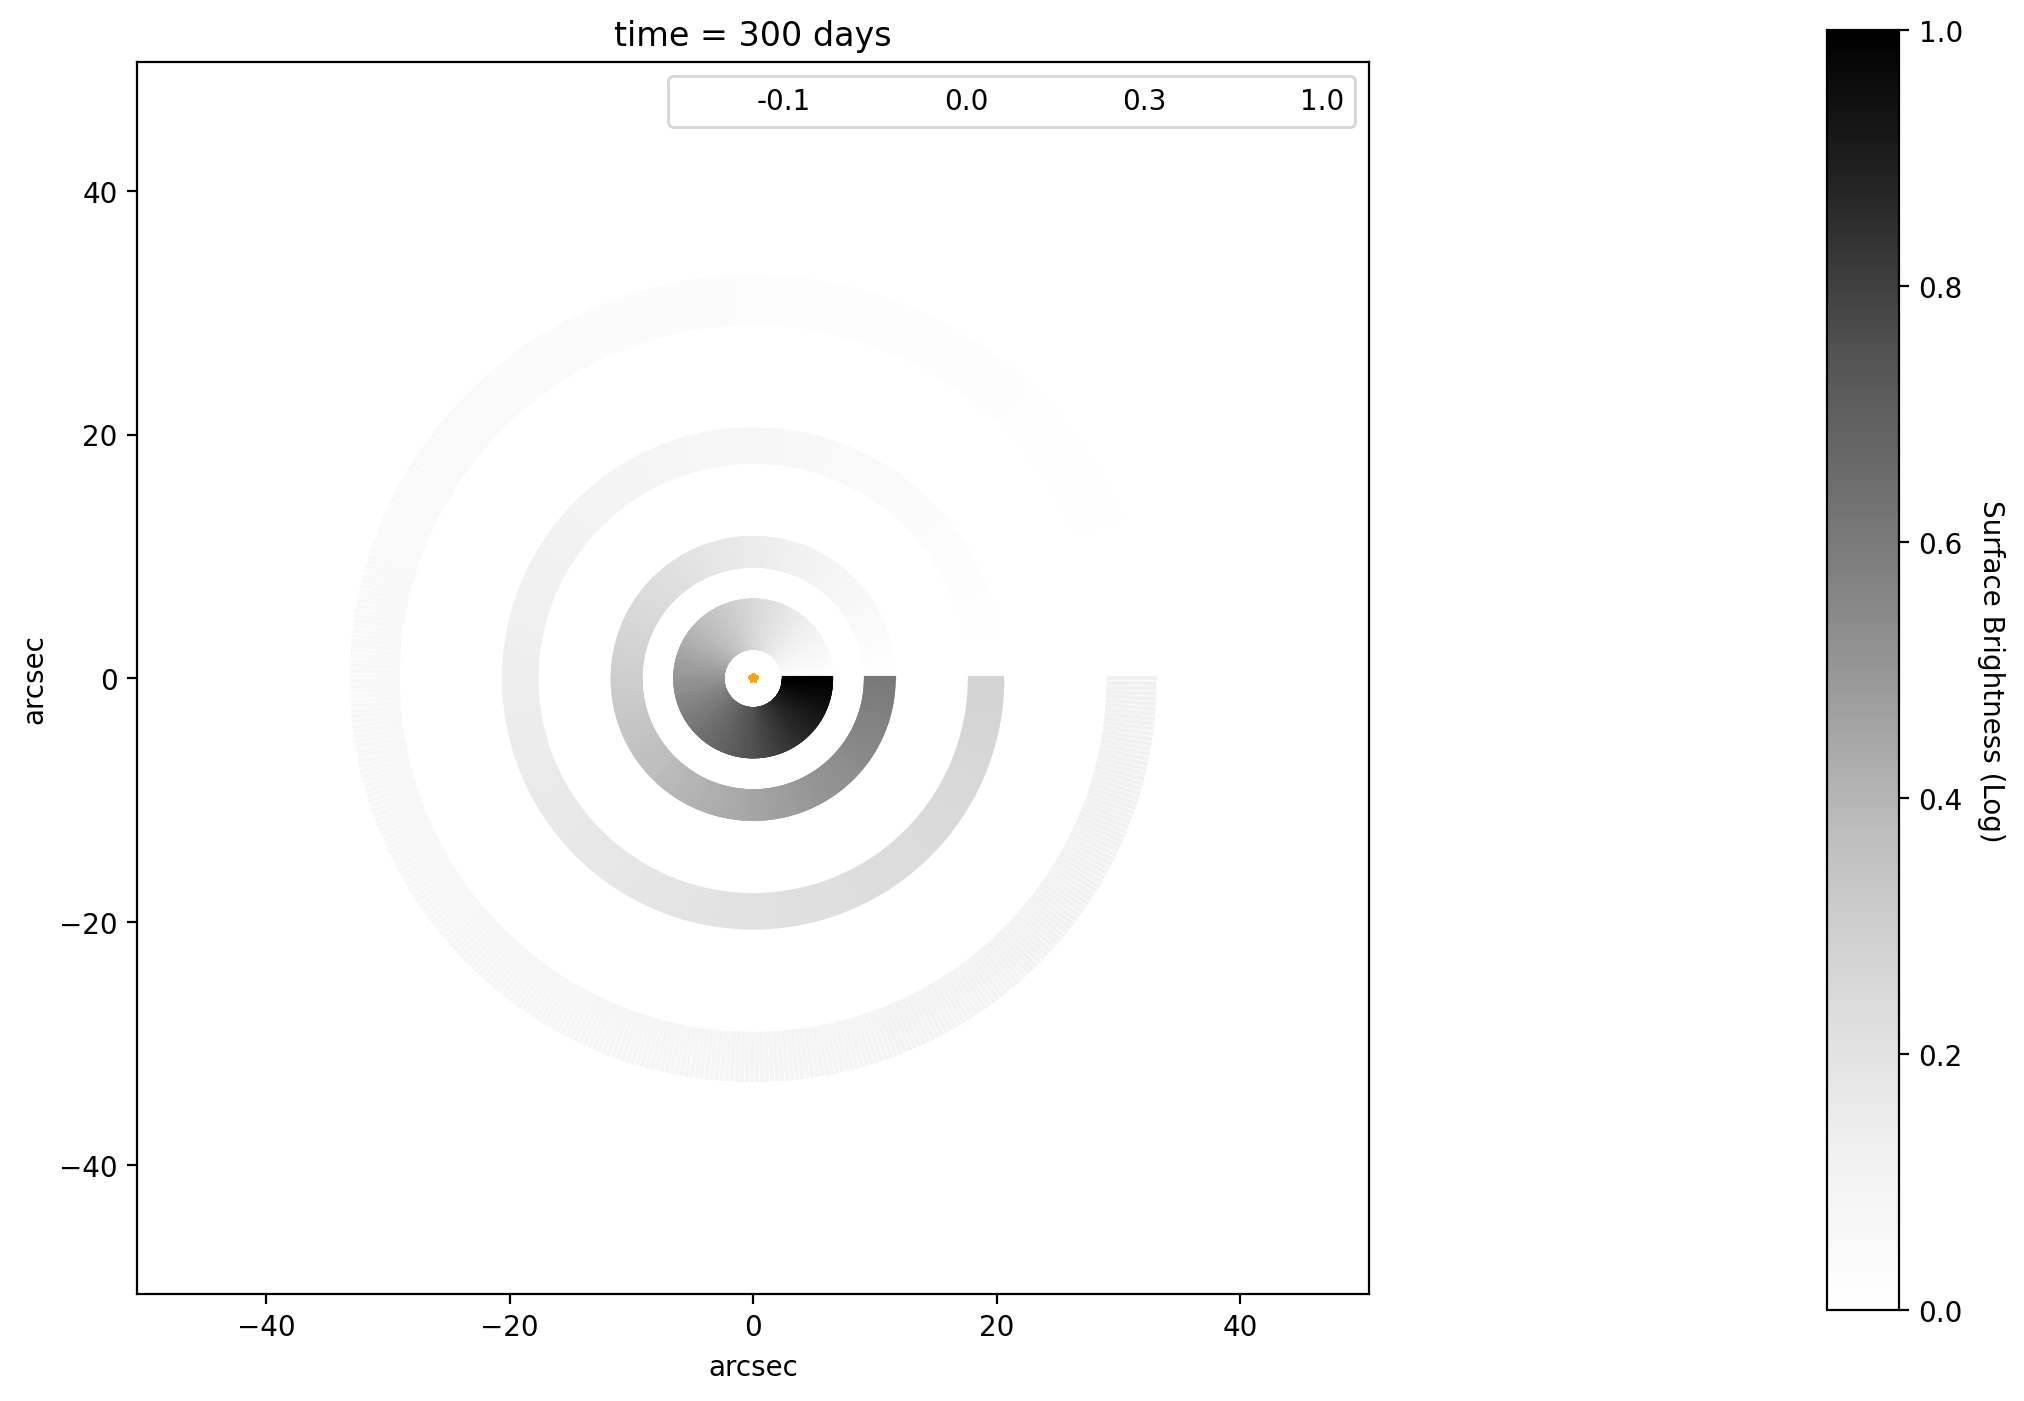

In [28]:
surface, Nd = final_plot(300, phi_min = 0, phi_max = 2 * np.pi)

(500,)
(1, 500)
(1, 4, 500)


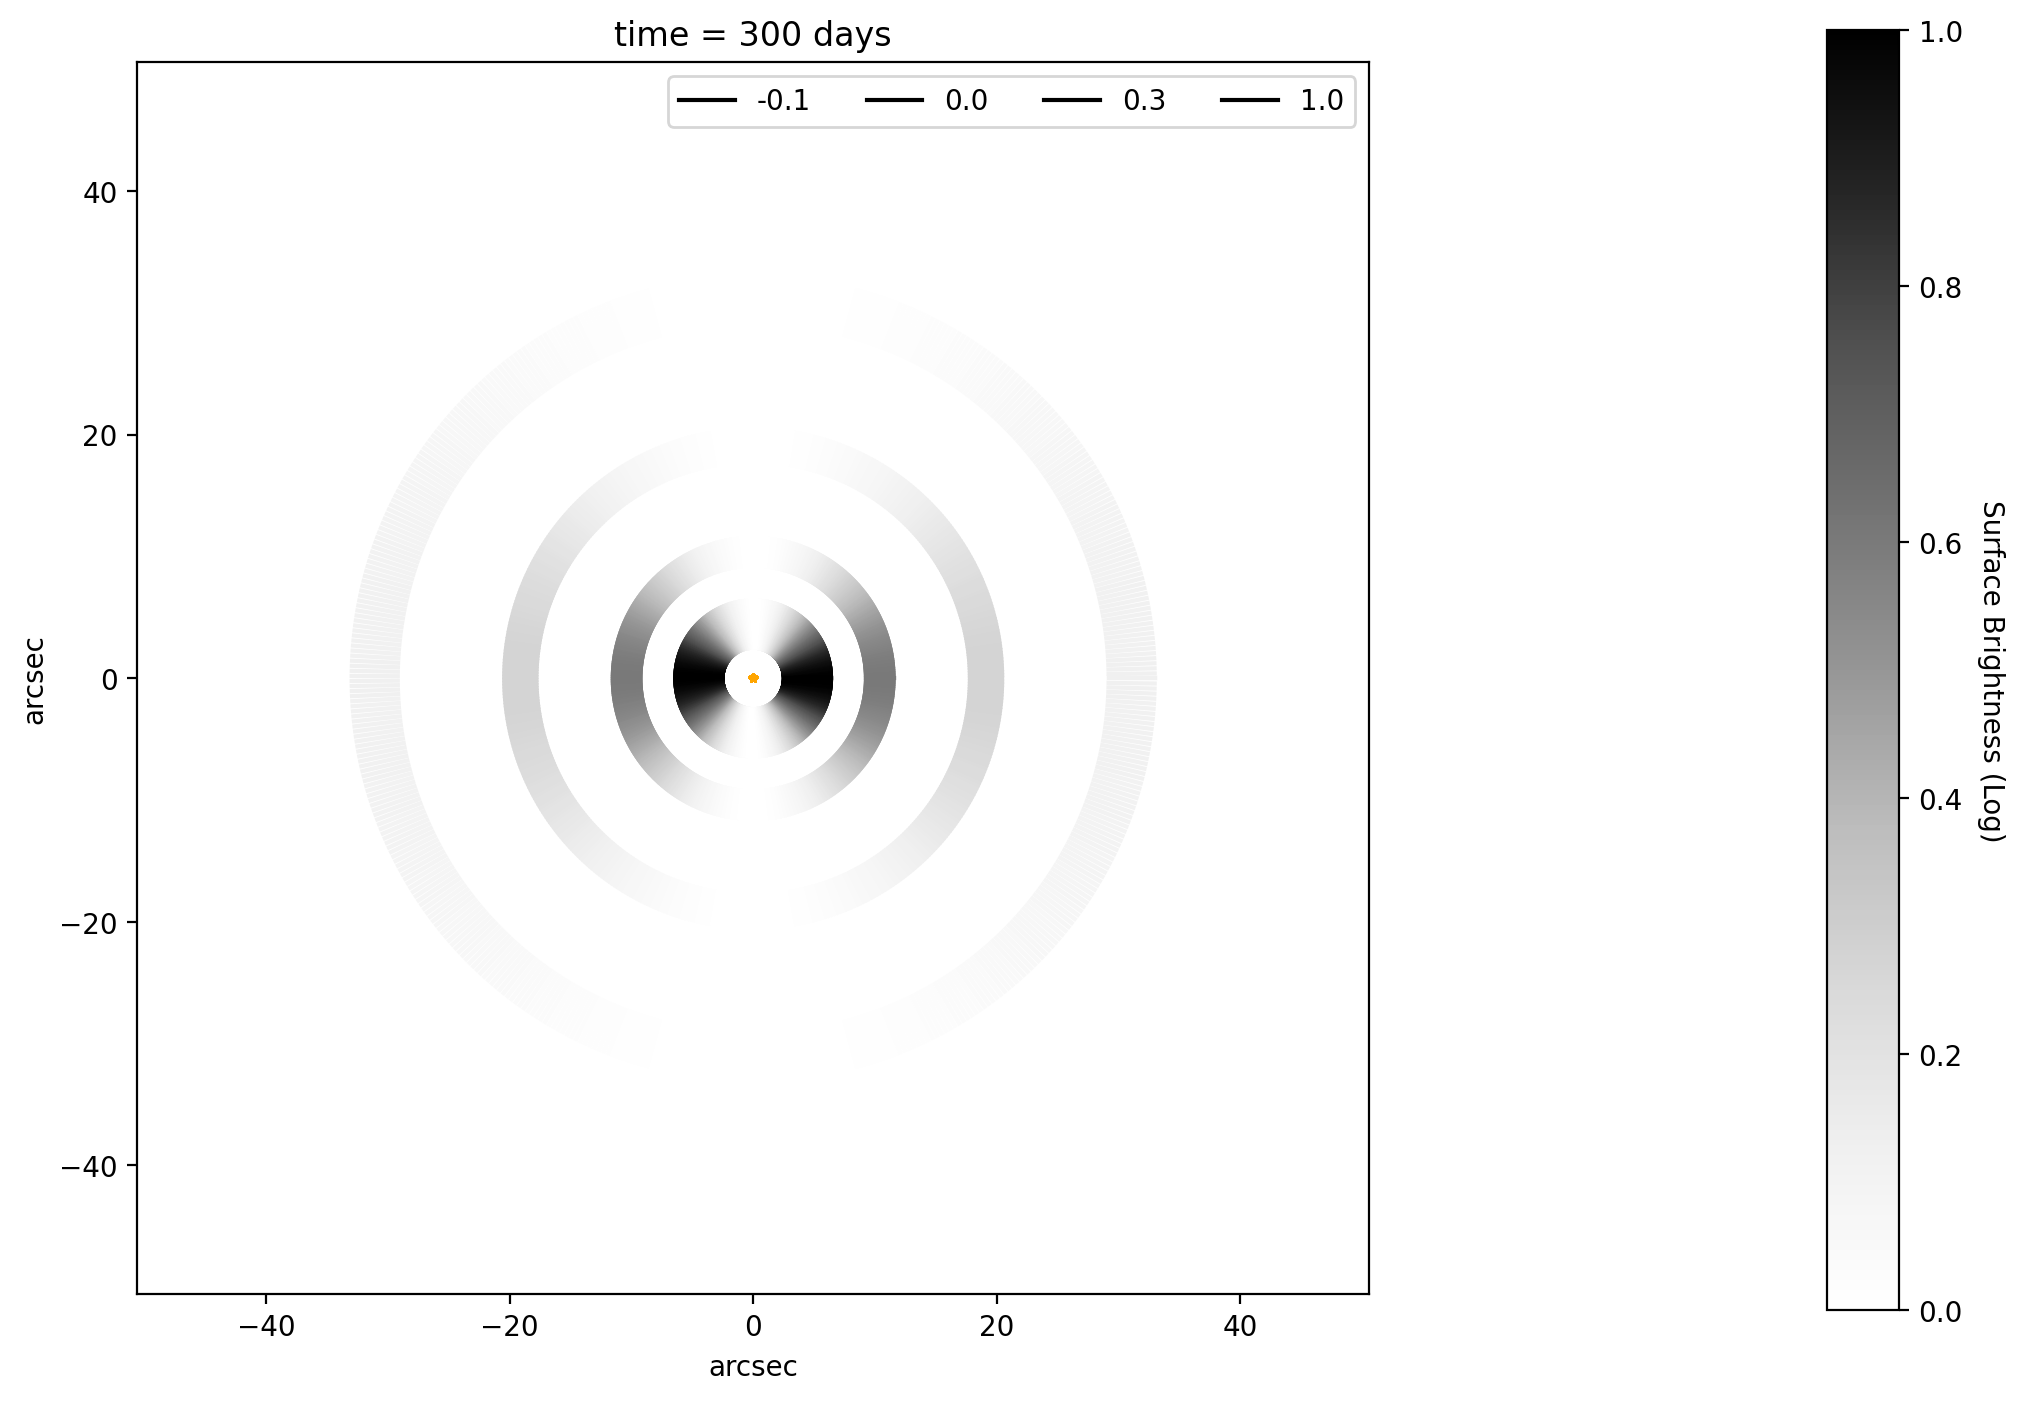

In [29]:
surface, Nd = final_plot(300, phi_min = 0, phi_max = 2 * np.pi, func = np.cos, k = 2)

(500,)
(1, 500)
(1, 4, 500)


<ipython-input-27-09f047470030>:17: RuntimeWarning: invalid value encountered in arcsin
  Nd = np.array([nh_phi_plus_power(func(phi), k)]).reshape(1, len(phi))


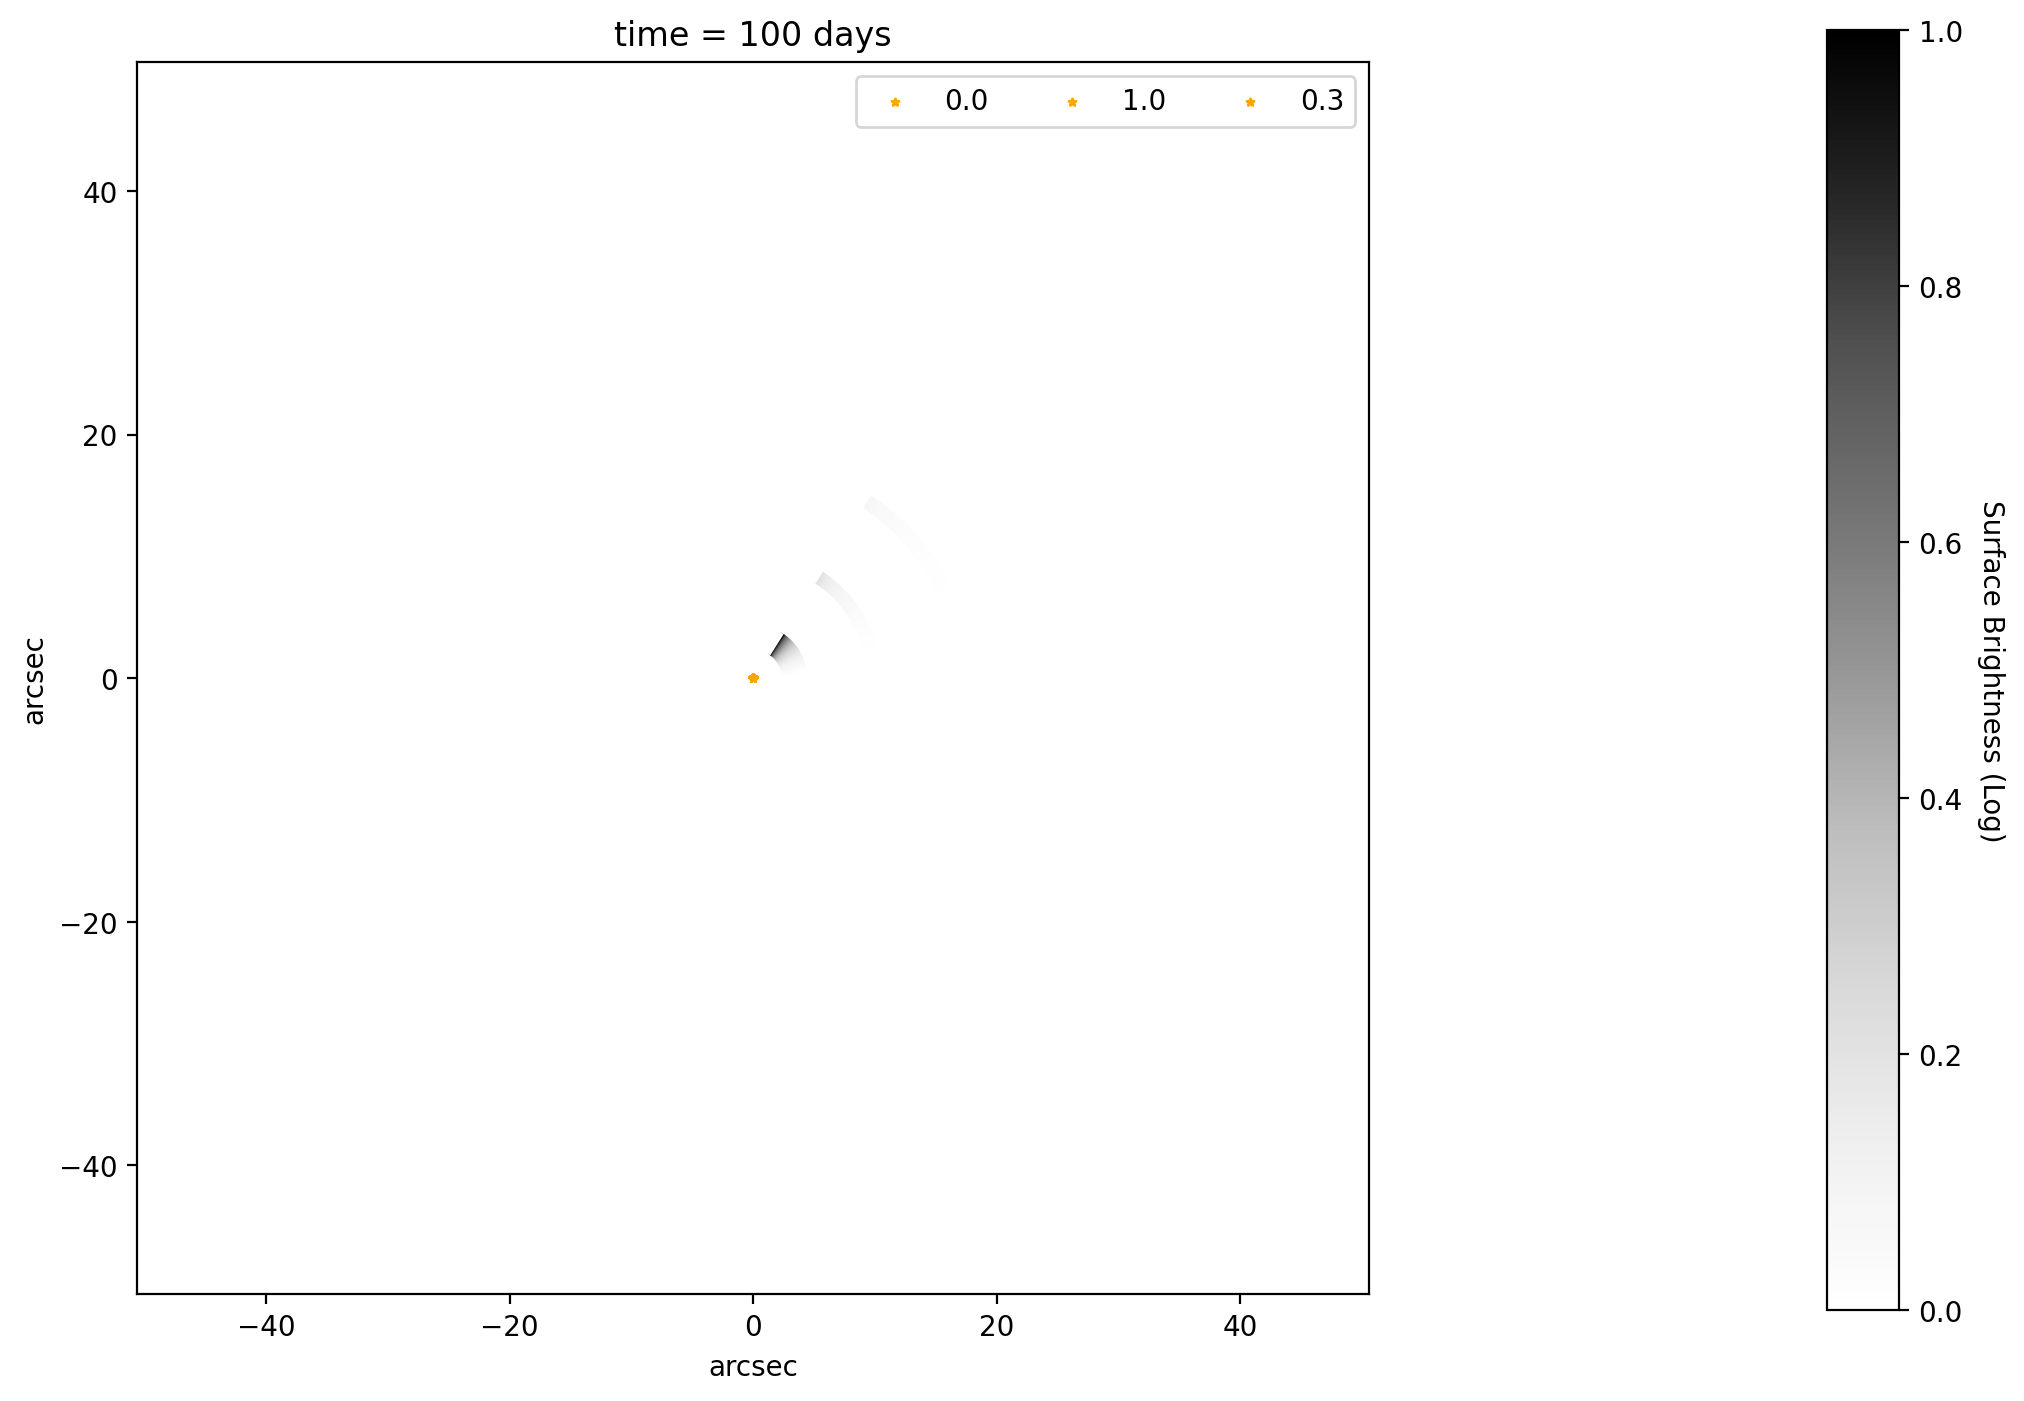

In [30]:
surface, Nd = final_plot(100, phi_min = 0, phi_max = 2 * np.pi, func = np.arcsin, k = 2)

(500,)
(1, 500)
(1, 4, 500)


<ipython-input-24-f1a3d270e36e>:13: RuntimeWarning: invalid value encountered in power
  nh = n_h * params ** k


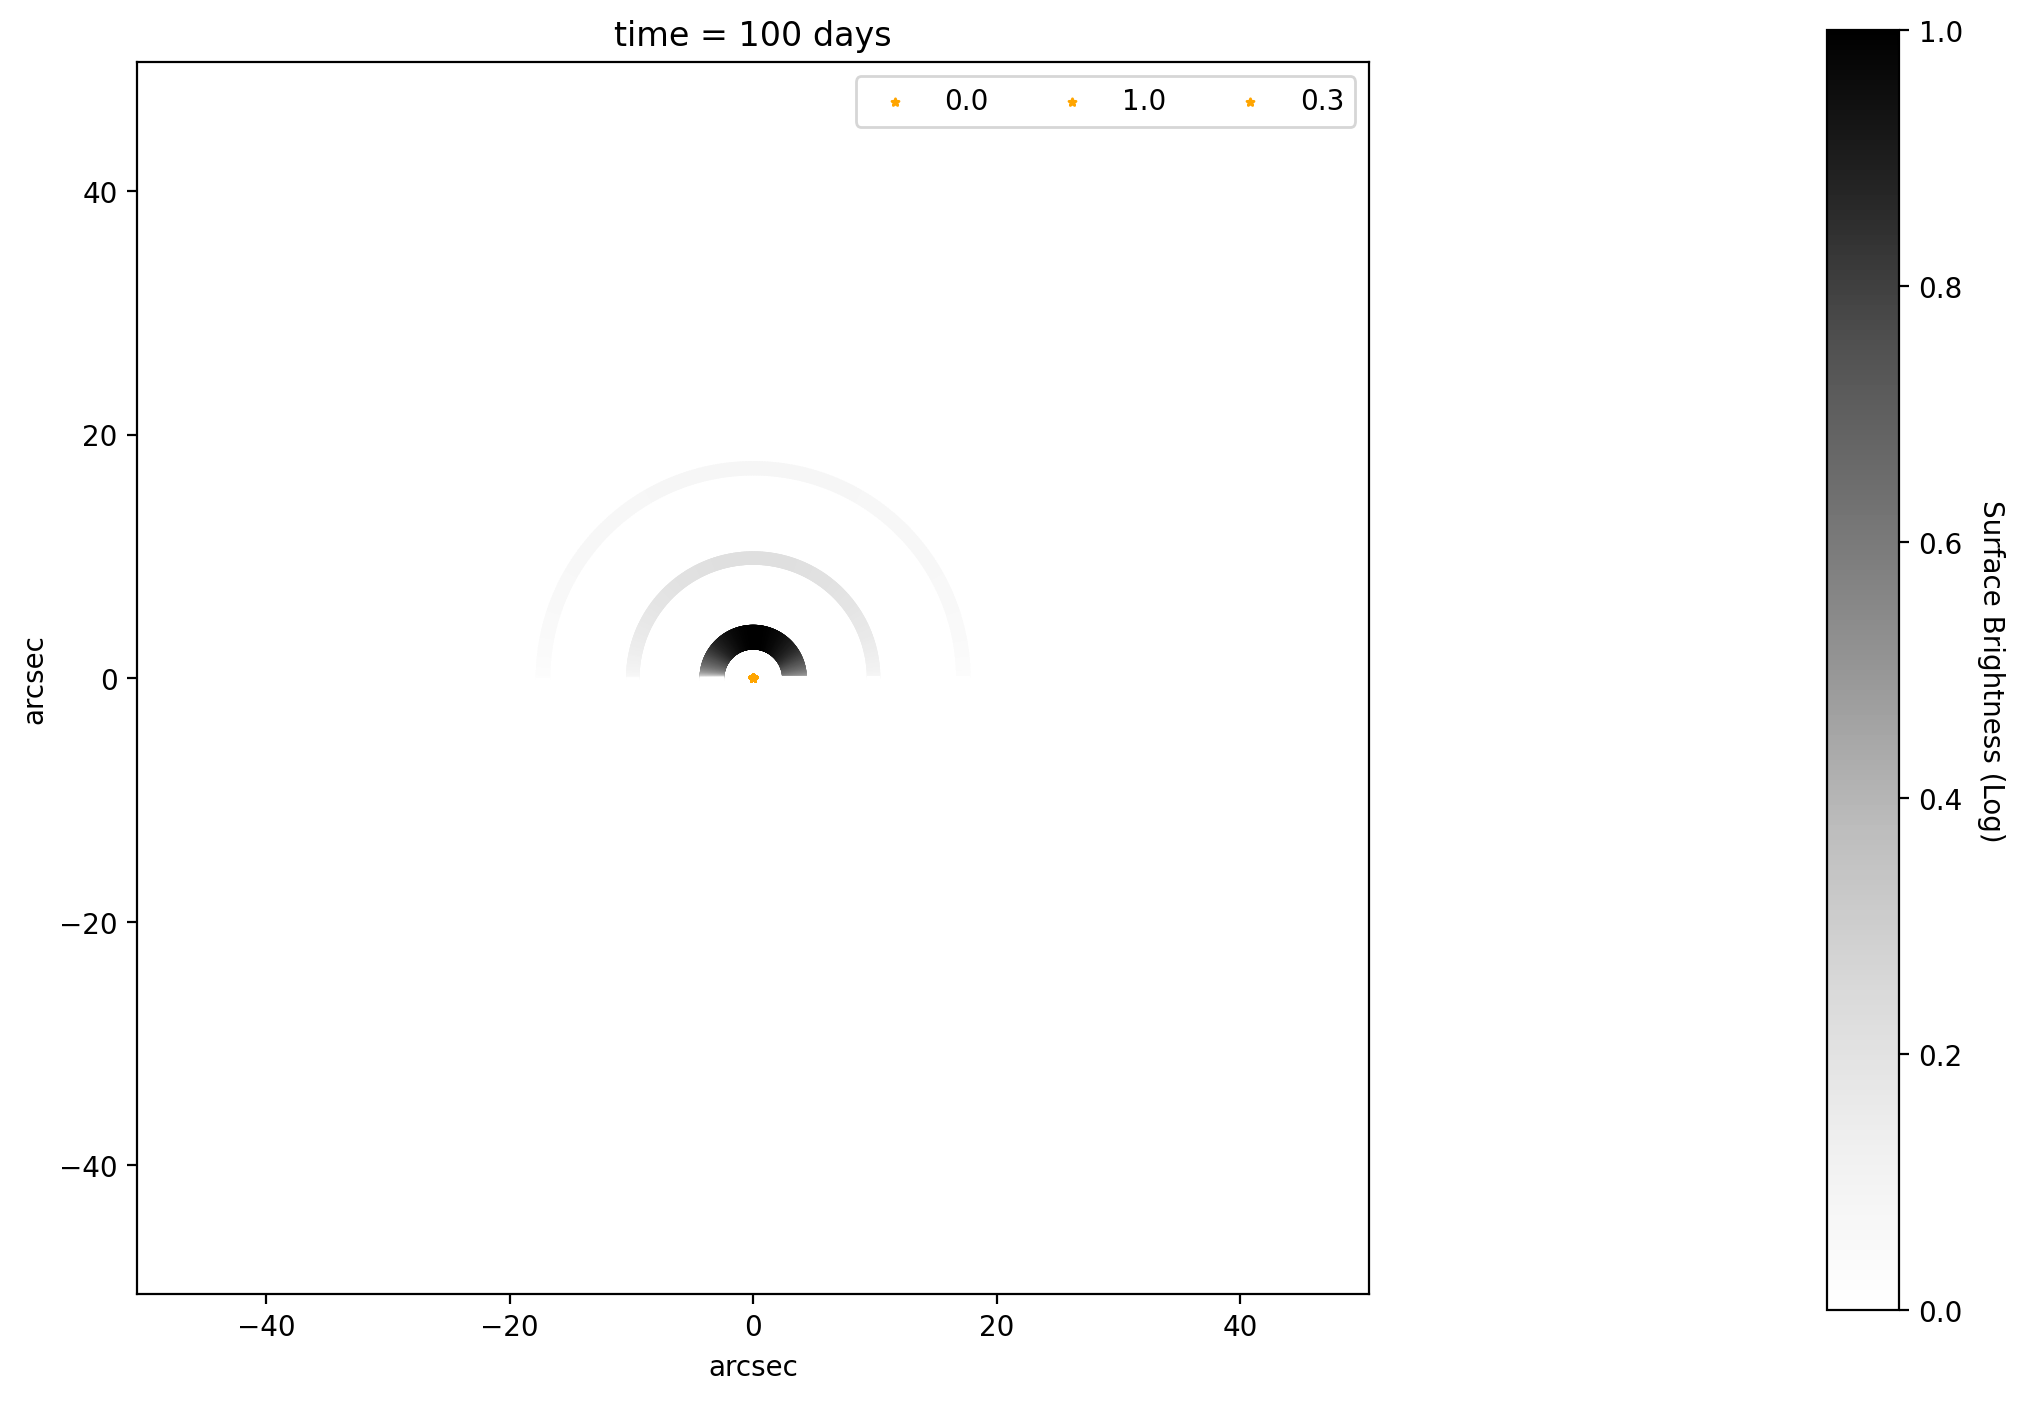

In [31]:
surface, Nd = final_plot(100, phi_min = 0, phi_max = 2 * np.pi, func = np.sin, k = 0.3)

(500,)
(1, 500)
(1, 4, 500)


<ipython-input-24-f1a3d270e36e>:13: RuntimeWarning: invalid value encountered in power
  nh = n_h * params ** k


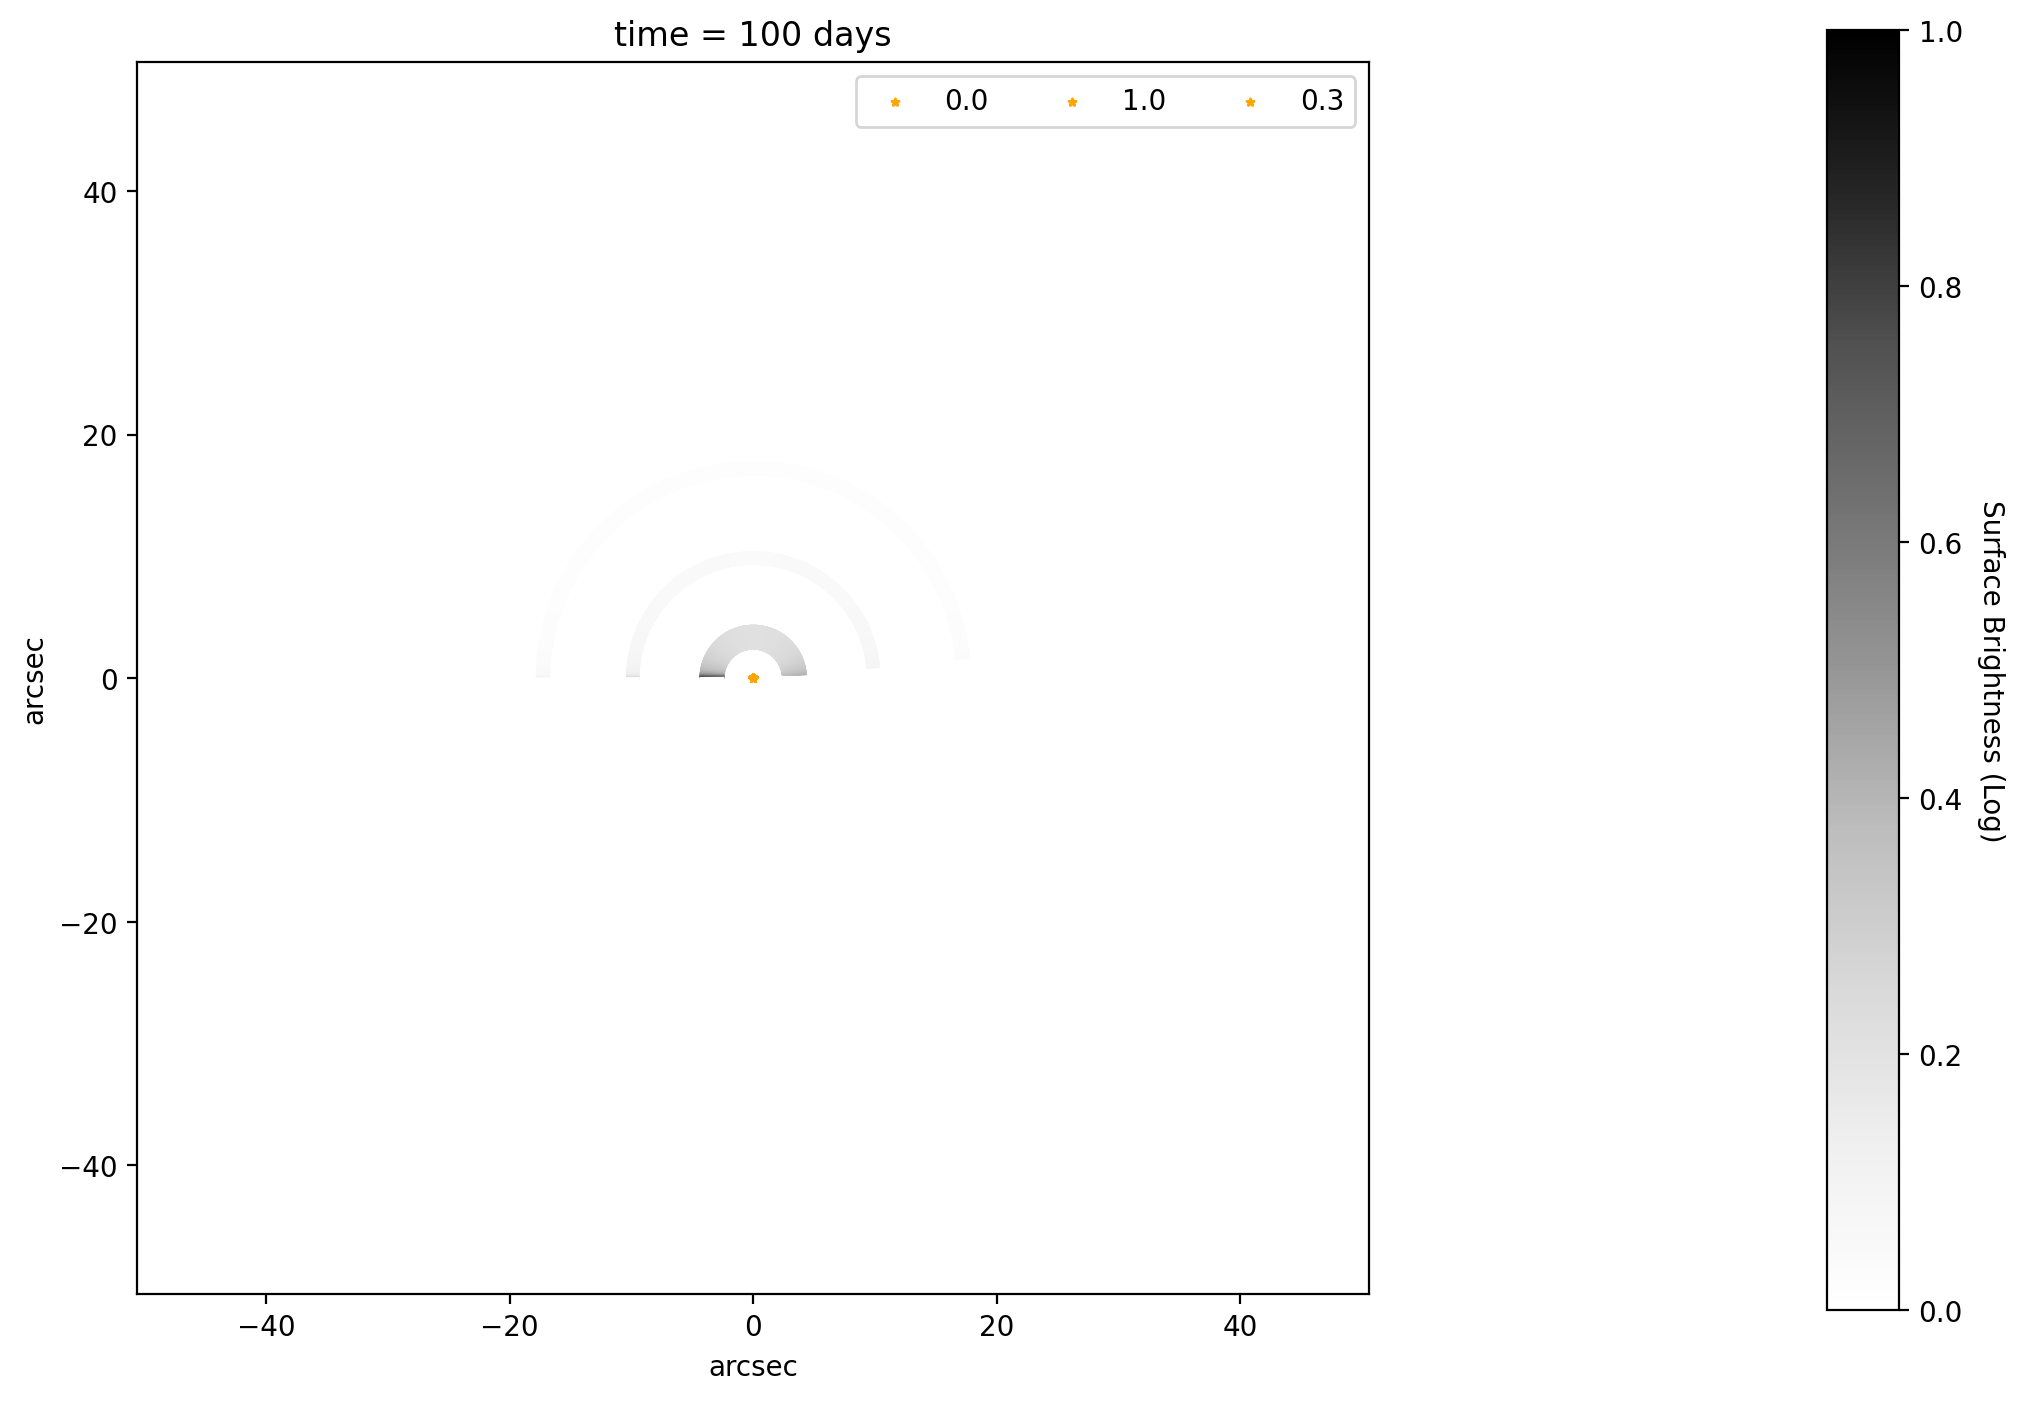

In [32]:
surface, Nd = final_plot(100, phi_min = 0.1, phi_max = 2 * np.pi, func = np.sin, k = -0.3)


(300,)
(1, 300)
(1, 4, 300)


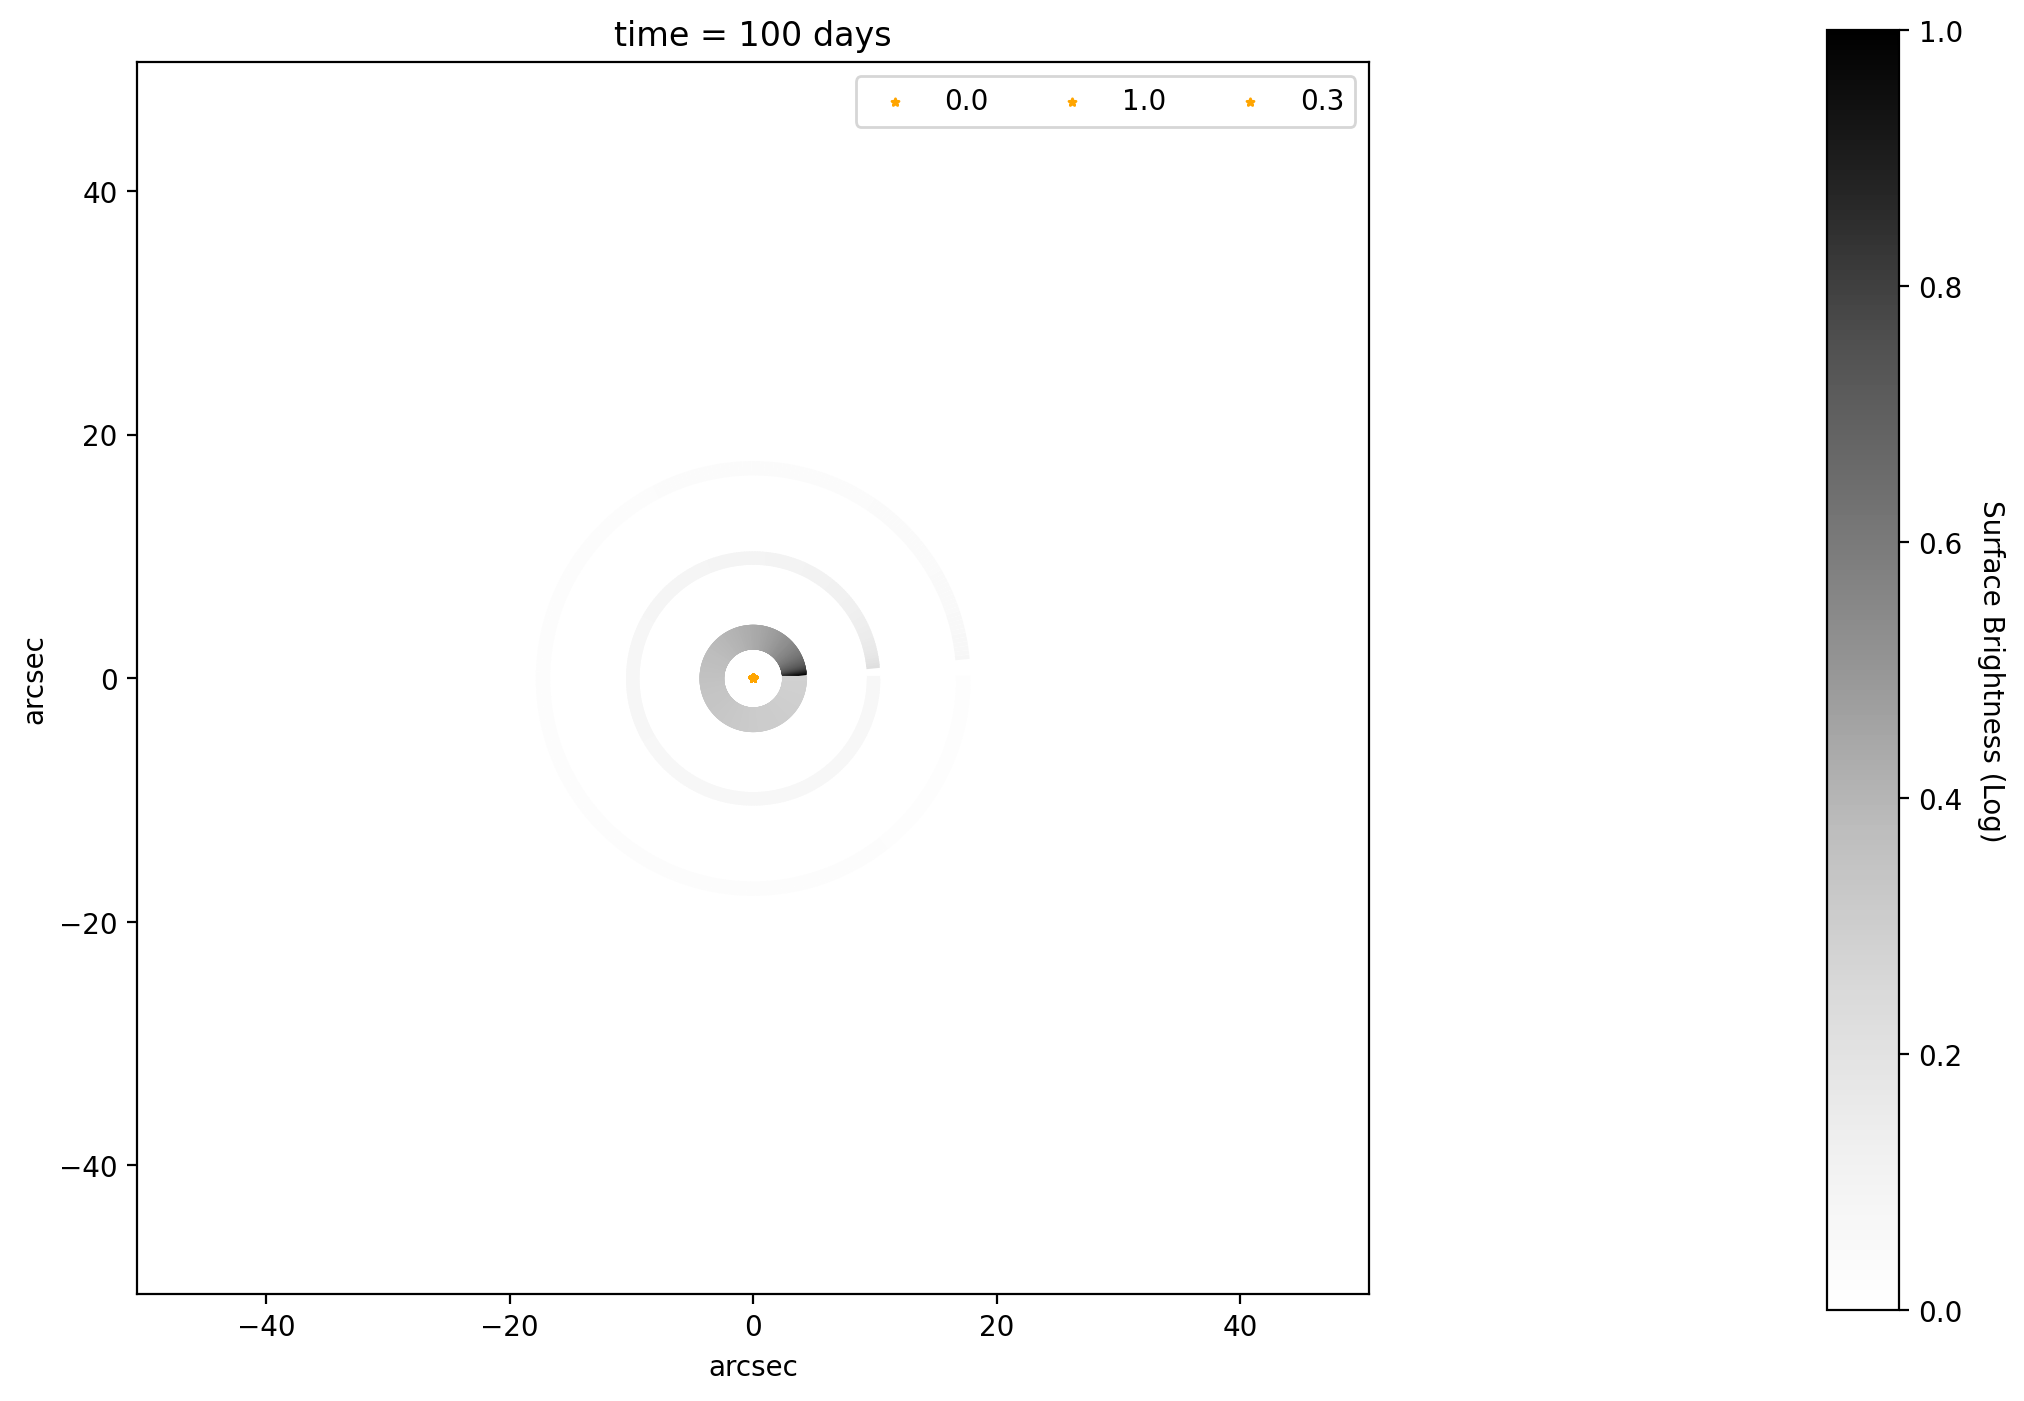

In [33]:
surface, Nd = final_plot(100, phi_min = 0.1, phi_max = 2 * np.pi, size_phi = 300, func = 1, k = -0.3)


# Density = nh * func(ɸ) * x$^k$

In [34]:
def nh_phi_plus_x_dependence(params, x, k = 1, n_h = n):
  """
    Define the density as a pairwise function that depends on the angle phi, the angle in the x,y sky plane
    Arguments
        params: list/array/tuple with the phi angle to be evaluate
        phi_min: min phi where the density value exist
        phi_max: min phi where the density value exist
        n_h: density value
    Return
        Value of the density with same shape as params
  """

  nh = n_h * params * (x ** k)
  nh = np.nan_to_num(nh, nan = 0)
  return nh

In [35]:
def surface_brightness_plane_x(Deltat_y, z0ly, dz0, func, phi, density_func):
  """
    Arguments
        Deltat_y: time when the snap of the LE is taken by observer, in year
        z0ly: sitance of the dust in light-years
        dz0: thickness of the plane dust
        Nd: density
  """

  # phi = np.linspace(0, 2*np.pi, 100)
  # Nd = np.array([nh_phi_plus_power(phi, [phi_min[0], phi_min[1]], [phi_max[0], phi_max[1]], k = -2)]).reshape(2, 100)
  # print(len(Nd), Nd.shape)
  surface = np.zeros((len(Deltat_y), len(z0ly), len(phi)))
  print(surface.shape)
  for j, time in enumerate(Deltat_y):
    ct = time * c
    for i, z in enumerate(z0ly):
      if z < 0:
        # print(z)
        ti = (-2 * z)/(c * (1 + a**2))
        # print(ti)
        if time >= ti:
          # print(z)
          r_le = np.sqrt(2 * z * ct + (ct)**2 * (1 + a**2) )
          # print(r_le)
          x = r_le * np.cos(phi) - a * ct
          if isinstance(func, (int, float)):
            Nd = np.array([density_func(func * phi, x, k)]).reshape(1, len(phi))
          elif callable(func):
            Nd = np.array([density_func(func(phi), x, k)]).reshape(1, len(phi))
          # -- distance source - dust
          r = z - a * x + ct
          # -- rho = x^2 + y^2 = r_le
          rhodrho  = 0.5 * (dz0 - a * x + c * dt0)
          # print(len(x), len(theta))
          surface[j, i, :] = Ir * Nd * dz0 / ( 4 * np.pi * r * rhodrho)
        elif time < ti:
          surface[j, i, :] = Ir * np.zeros(len(phi))
      elif z >= 0:
        ti = 0
        if time >= 0:
          r_le = np.sqrt(2 * z * ct + (ct)**2 * (1 + a**2))
          # print((ct / c) / dtoy)
          x = r_le * np.cos(phi) - a * ct
          if isinstance(func, (int, float)):
            Nd = np.array([density_func(func * phi, x, k)]).reshape(1, len(phi))
          elif callable(func):
            Nd = np.array([density_func(func(phi), x, k)]).reshape(1, len(phi))
          # print(j, i)
          # -- distance source - dust
          r = z - a * x + ct
          # print(r)
          # -- rho = x^2 + y^2 = r_le
          rhodrho  = 0.5 * (dz0 - a * x + c * dt0)
          # print(rhodrho)
          surface[j, i, :] = Ir * Nd * dz0 / ( 4 * np.pi * r * rhodrho)
          # print(j, i, surface[j, i, :])


  surface = surface.reshape(len(Deltat), len(z0ly), max(Nd.shape))
  # print(surface.shape)

  # surface_norm = (mean - np.nanmin(mean)) / (np.nanmax(mean) - np.nanmin(mean))
  # surface_norm = np.array(surface_norm).reshape(len(Deltat),len(z0ly), max(Nd.shape))

  return surface


In [36]:
def final_plot(delta_t, phi_min = 0, phi_max = 2 * np.pi, size_phi = 500, func = 1, k = 1, density_func = nh_phi, surface_func = surface_brightness_plane):
  Deltat = [delta_t] # days
  Deltat_y = np.array(Deltat) * dtoy

  z0 = [-0.10, 0, 0.3, 1] # pc
  z0ly = np.array(z0) * pctoly

  # z0ly = [-0.10, 0.1, 0.3, 1]
  # z0ly = [0.1 * pctoly]


  phi = np.linspace(phi_min, phi_max, size_phi)
  print(phi.shape)

  surface = surface_func(Deltat_y, z0ly, dz0, func, phi, density_func)
  # print((surface[0, 0, 0]))
  # print(np.argmin(surface))
  surface = ( surface.copy() - np.nanmin(surface.copy())  ) / (np.nanmax(surface.copy()) - np.nanmin(surface.copy()))
  # print((surface[0, 0, 0] - np.nanmin(surface)))


  # phi_min, phi_max = (104 / 180) * np.pi, (240 / 180) * np.pi
  # surface = surface_brightness_plane(Deltat_y, z0ly, dz0,  phi_min, phi_max)


  angle = phi.copy()
  cmap = matplotlib.colormaps.get_cmap('Greys')
  normalize = matplotlib.colors.Normalize(vmin=np.nanmin(surface), vmax=np.nanmax(surface))

  XX = []
  YY = []
  legend_dust = []
  fig, ax = plt.subplots(1, 1, figsize=(12, 8))
  for j, time in enumerate(Deltat_y):
    ct = time*c
    ax.set_title("time = %s days"%int(time/ dtoy))
    for i,z in enumerate(z0ly):
      for k in range(len(angle)):
          if z < 0:
            # -- time ring star expanding
            ti = (-2 * z)/(c * (1 + a**2))
            # print(ti)
            if time >= ti:
              xs, ys = xy_plane_ring(angle, z, ct, dz0, dt0, a, d)
              XX.append(xs)
              YY.append(ys)
              plot_plane_dust(ax, d, xs, ys, z, surface, j, i, k)
              legend_dust.append(z0ly[i] / pctoly)
              # ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4)
            else:
              ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
          else:
            ti = dt0
            # -- for time less than the duration of the flash light, all the dust within the paraboiloid define for the dust and the source would be illuminated.
            if time <= ti:
              # -- rin and rout for the most inner ring keeps the same
              index = [k for k, x in enumerate(z0ly) if x >= 0]
              if i == index[0]:
                print(i, z0ly[i] / pctoly)
                xs, ys = xy_plane_ring(angle, z, ct, dz0, dt0, a, d)
                XX.append(xs)
                YY.append(ys)
                plot_plane_dust(ax, d, xs, ys, z, surface, j, i, k)
                legend_dust.append(z0ly[i] / pctoly)
                ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
                # ax.legend(loc='upper left', ncol=1, fontsize='small', title = r"$z_0 (pc)$")
              else:
                # -- for the rest of the rings, rin is rout of the previous ring
                r_le_out = r_outin(z, ct, dz0, dt0, a, "out")
                r_le_in = r_outin(z0ly[i-1], ct, dz0, dt0, a, "out")
                print(z / pctoly, z0ly[i-1] / pctoly, r_le_out, r_le_in)
                radii = [r_le_out, r_le_in]
                xs = np.outer(radii, np.cos(angle)) - a * ct
                ys = np.outer(radii, np.sin(angle))
                # in order to have a closed area, the circles
                # should be traversed in opposite directions
                xs[1,:] = xs[1,::-1]
                ys[1,:] = ys[1,::-1]
                XX.append(xs)
                YY.append(ys)
                plot_plane_dust(ax, d, xs, ys, z, surface, j, i, k)
                ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
                # ax.legend(loc='upper left', ncol=1, fontsize='small', title = r"$z_0 (pc)$")
            elif time > ti:
              xs, ys = xy_plane_ring(angle, z, ct, dz0, dt0, a, d)
              XX.append(xs)
              YY.append(ys)
              plot_plane_dust(ax, d, xs, ys, z, surface, j, i, k)
              legend_dust.append(z0ly[i] / pctoly)
              ax.scatter(-a * ct,0, marker="*", s=7, color="orange")
              # ax.legend(loc='upper left', ncol=1, fontsize='small', title = r"$z_0 (pc)$")
      ax.legend(set(legend_dust), loc='best',  ncol=4)

  cbax = fig.add_axes([0.96, 0.1, 0.03, 0.80])

  ax.set_xlabel("arcsec")
  ax.set_ylabel("arcsec")
  ax.set_box_aspect(1)

  cb = matplotlib.colorbar.ColorbarBase(cbax, cmap=cmap, norm=normalize, orientation='vertical')
  cb.set_label("Surface Brightness (Log)", rotation=270, labelpad=15)

  def label_cbrt(x,pos):
      return "{:.1f}".format(x)

  # cb.formatter = matplotlib.ticker.FuncFormatter(label_cbrt)
  cb.update_ticks()
  # plt.tight_layout()
  # plt.savefig("figure2.png", dpi = 700, bbox_inches='tight')
  # print(set(legend_dust))
  plt.show()

  return surface, Nd

(300,)
(1, 4, 300)


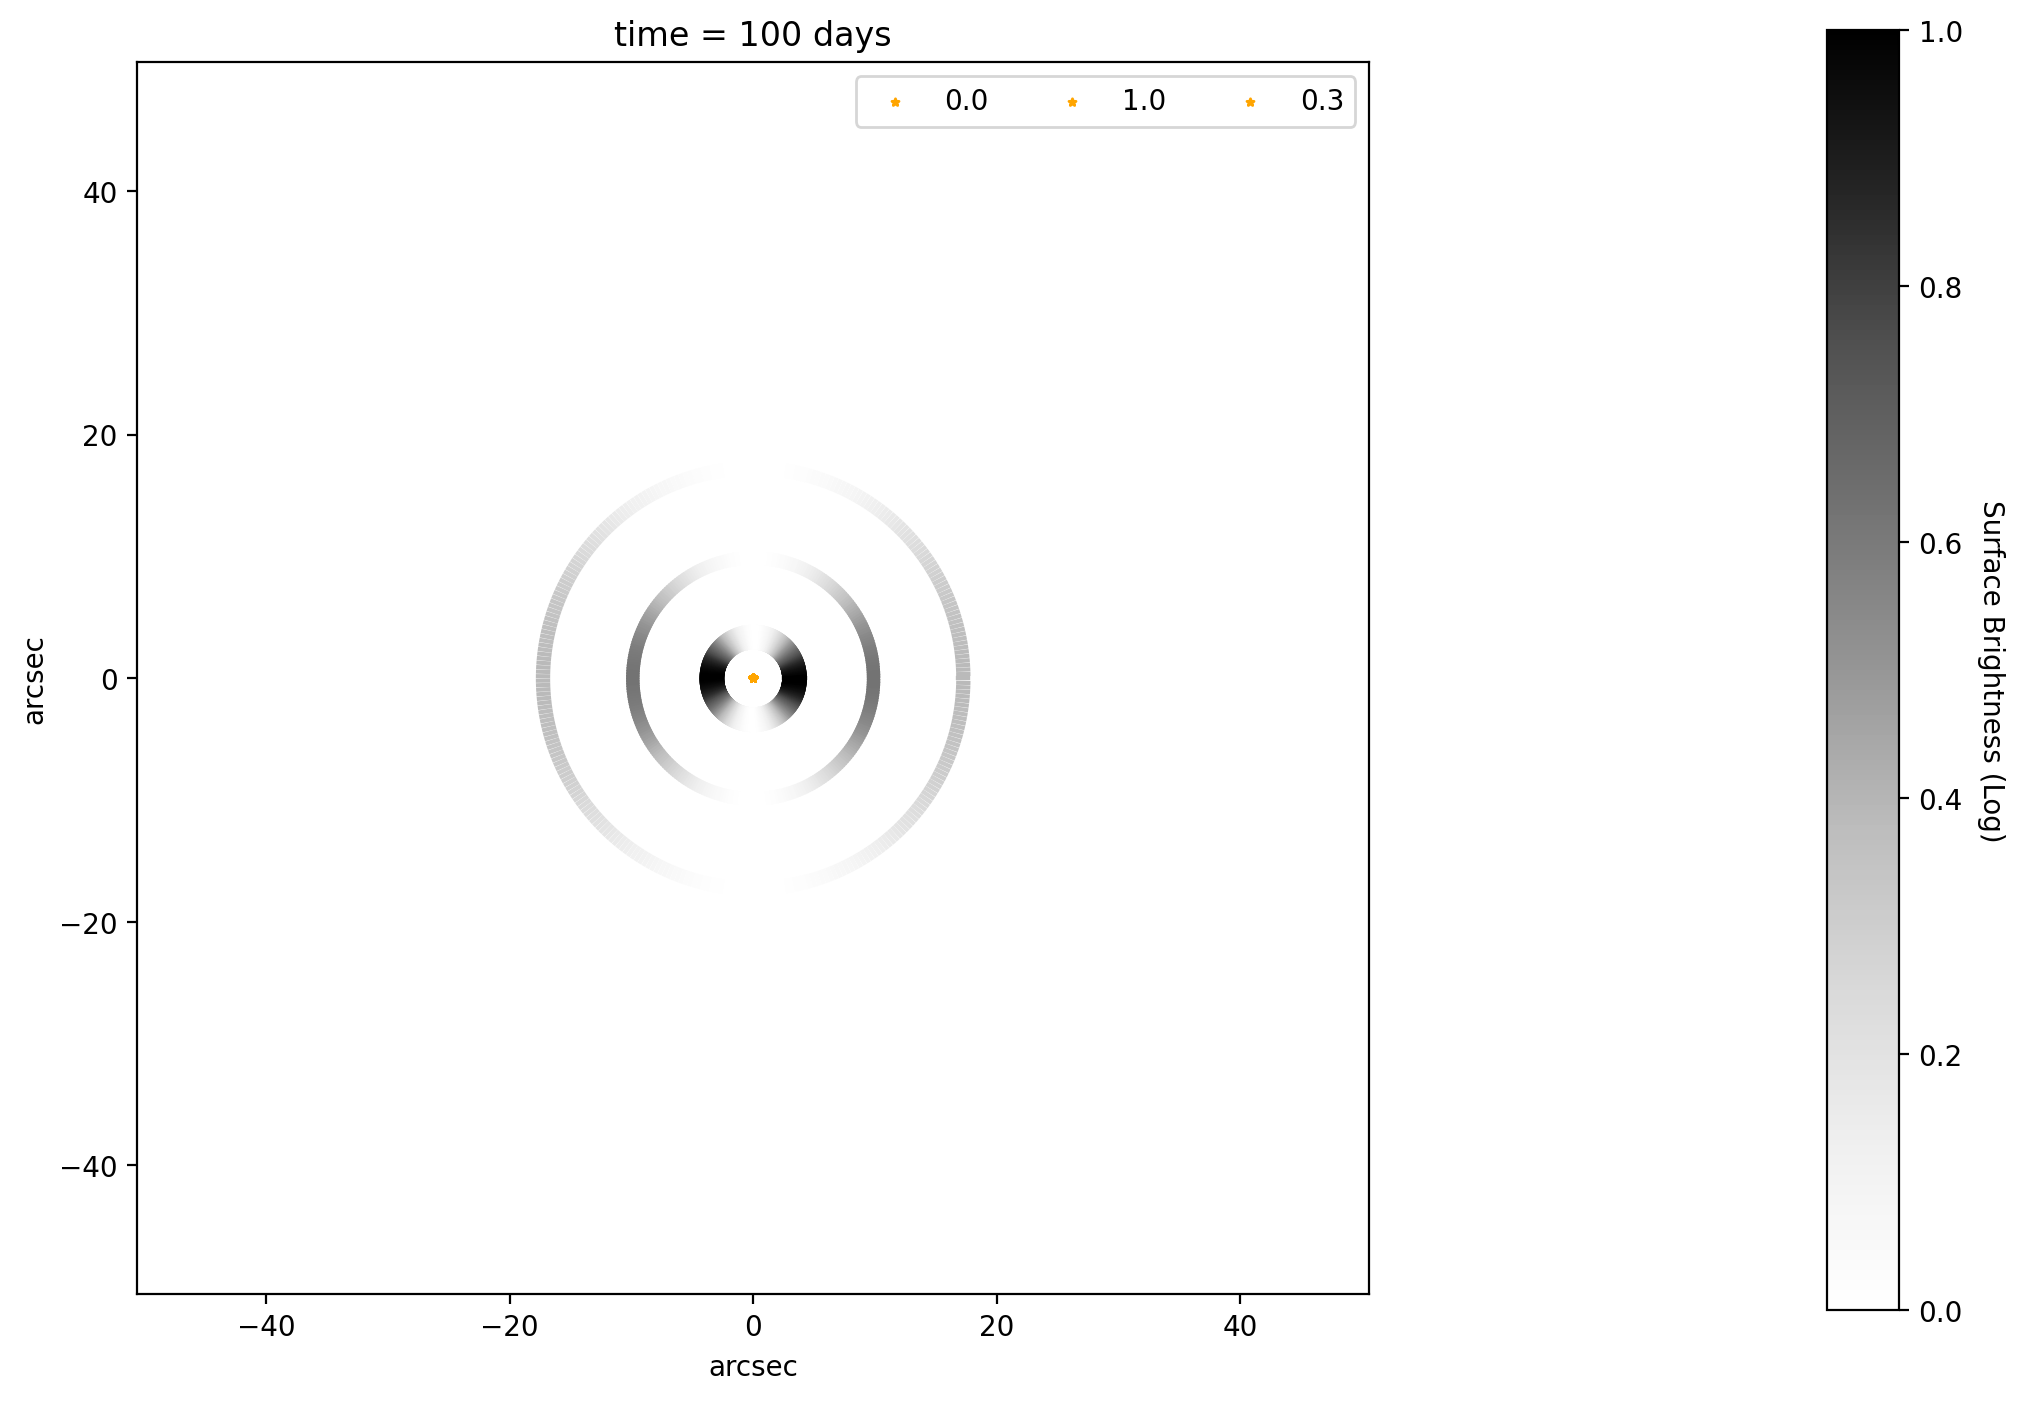

In [37]:
surface, Nd = final_plot(100, phi_min = 0, phi_max = 2 * np.pi, size_phi = 300, func = np.cos, k = 0.2, density_func = nh_phi_plus_x_dependence,
                         surface_func = surface_brightness_plane_x)


In [38]:
surface[0,0,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.


#MAKE EACH DUST PLANE WITH A DIFFERENT DENSITY

## Density = nH * func(ɸ) * (z$^k$)

In [39]:
def nh_phi_plus_z_dependence(params, z, k = 1, n_h = n):
  """
    Define the density as a pairwise function that depends on the angle phi, the angle in the x,y sky plane
    Arguments
        params: list/array/tuple with the phi angle to be evaluate
        phi_min: min phi where the density value exist
        phi_max: min phi where the density value exist
        n_h: density value
    Return
        Value of the density with same shape as params
  """

  nh = n_h * params * (z ** k)
  nh = np.nan_to_num(nh, nan = np.inf)
  return nh

In [40]:
def surface_brightness_plane_z(Deltat_y, z0ly, dz0, func, phi, density_func):
  """
    Arguments
        Deltat_y: time when the snap of the LE is taken by observer, in year
        z0ly: sitance of the dust in light-years
        dz0: thickness of the plane dust
        Nd: density
  """

  # phi = np.linspace(0, 2*np.pi, 100)
  # Nd = np.array([nh_phi_plus_power(phi, [phi_min[0], phi_min[1]], [phi_max[0], phi_max[1]], k = -2)]).reshape(2, 100)
  # print(len(Nd), Nd.shape)
  surface = np.zeros((len(Deltat_y), len(z0ly), len(phi)))
  print(surface.shape)
  for j, time in enumerate(Deltat_y):
    ct = time * c
    for i, z in enumerate(z0ly):
      if isinstance(func, (int, float)):
        Nd = np.array([density_func(func * phi, np.abs(z), k)]).reshape(1, len(phi))
      elif callable(func):
        Nd = np.array([density_func(func(phi), np.abs(z), k)]).reshape(1, len(phi))
      if z < 0:
        # print(z)
        ti = (-2 * z)/(c * (1 + a**2))
        print(ti)
        if time >= ti:
          # print(z)
          r_le = np.sqrt(2 * z * ct + (ct)**2 * (1 + a**2) )
          # print(r_le)
          x = r_le * np.cos(phi) - a * ct
          # -- distance source - dust
          r = z - a * x + ct
          # -- rho = x^2 + y^2 = r_le
          rhodrho  = 0.5 * (dz0 - a * x + c * dt0)
          # print(len(x), len(theta))
          surface[j, i, :] = Ir * Nd * dz0 / ( 4 * np.pi * r * rhodrho)
        elif time < ti:
          print(time, j, i)
          surface[j, i, :] = Ir * np.zeros(len(phi))
          # print((surface[j, i, :]))
      elif z >= 0:
        ti = 0
        if time >= 0:
          # print(j, i)
          r_le = np.sqrt(2 * z * ct + (ct)**2 * (1 + a**2))
          # print((ct / c) / dtoy)
          x = r_le * np.cos(phi) - a * ct
          # print(x, np.cos(phi))
          # -- distance source - dust
          r = z - a * x + ct
          # print(r)
          # -- rho = x^2 + y^2 = r_le
          rhodrho  = 0.5 * (dz0 - a * x + c * dt0)
          # print(rhodrho)
          surface[j, i, :] = Ir * Nd * dz0 / ( 4 * np.pi * r * rhodrho)
          # print(j, i, Nd, surface[j, i, :])


  surface = surface.reshape(len(Deltat), len(z0ly), max(Nd.shape))
  # print((surface[0, 3, :]))

  # print(surface.shape)

  # surface_norm = (mean - np.nanmin(mean)) / (np.nanmax(mean) - np.nanmin(mean))
  # surface_norm = np.array(surface_norm).reshape(len(Deltat),len(z0ly), max(Nd.shape))

  return surface


(300,)
(1, 4, 300)
0.652312
0.273973 0 0


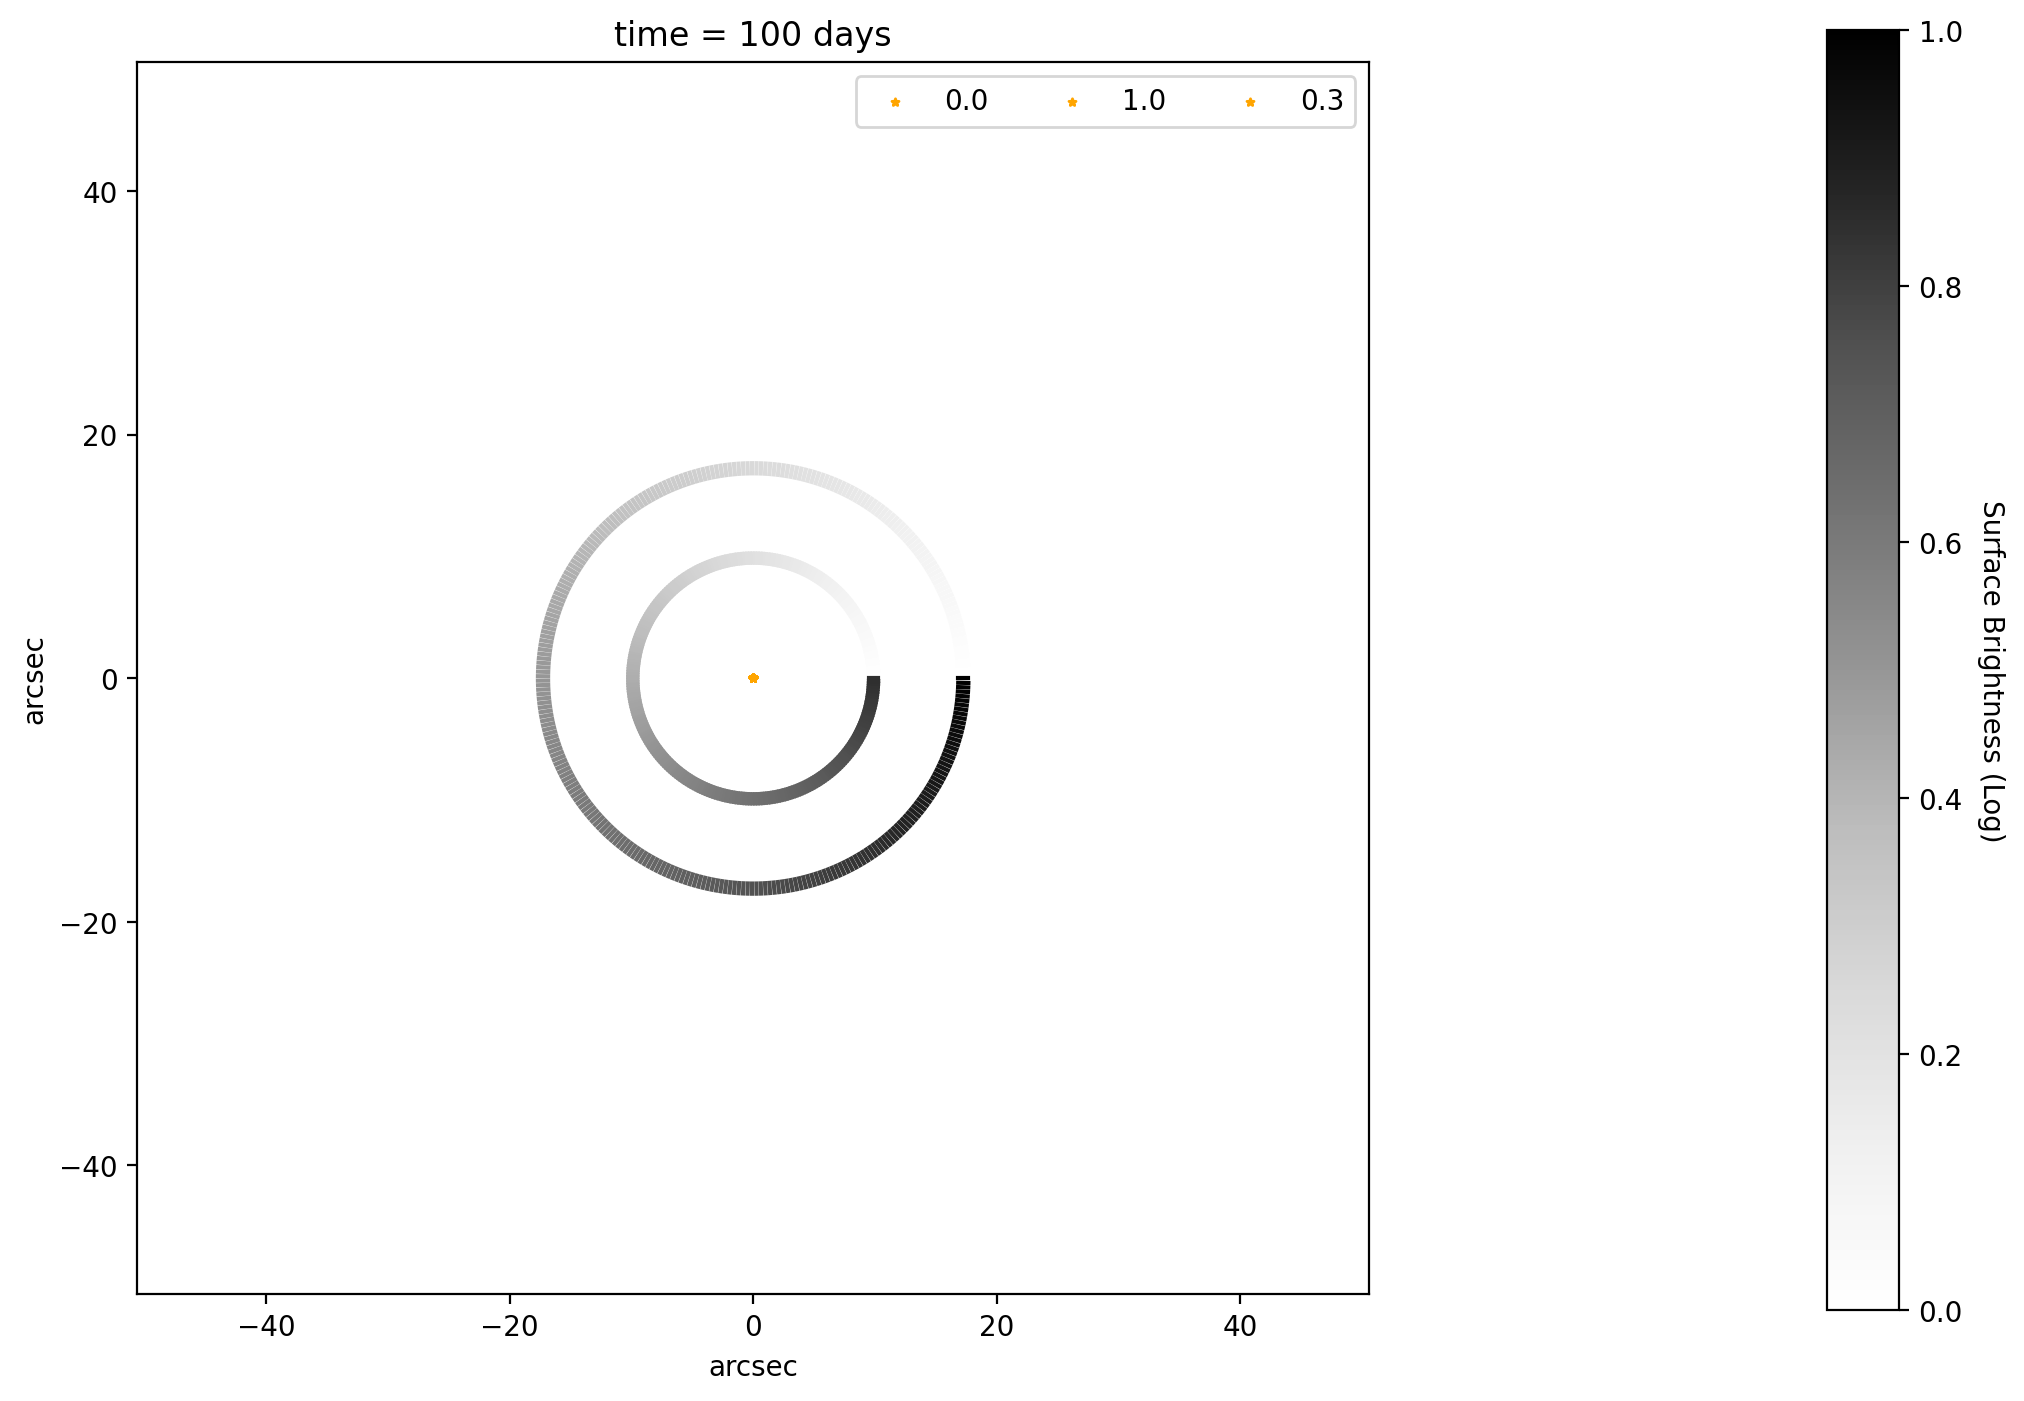

In [41]:
surface, Nd = final_plot(100, phi_min = 0, phi_max = 2 * np.pi, size_phi = 300, func = 1, k = 1, density_func = nh_phi_plus_z_dependence,
                         surface_func = surface_brightness_plane_z)
# when func is cos or sin, the density is negative at somes phis

# Density = nH * func(ɸ)* (x$^2$ + x + k)

In [42]:
def nh_phi_plus_xx_dependence(params, x, k = 1, n_h = n):
  """
    Define the density as a pairwise function that depends on the angle phi, the angle in the x,y sky plane
    Arguments
        params: list/array/tuple with the phi angle to be evaluate
        phi_min: min phi where the density value exist
        phi_max: min phi where the density value exist
        n_h: density value
    Return
        Value of the density with same shape as params
  """

  nh = n_h * params * (x ** 2 + x + k)
  nh = np.nan_to_num(nh, nan = np.inf)
  return nh

(500,)
(1, 4, 500)


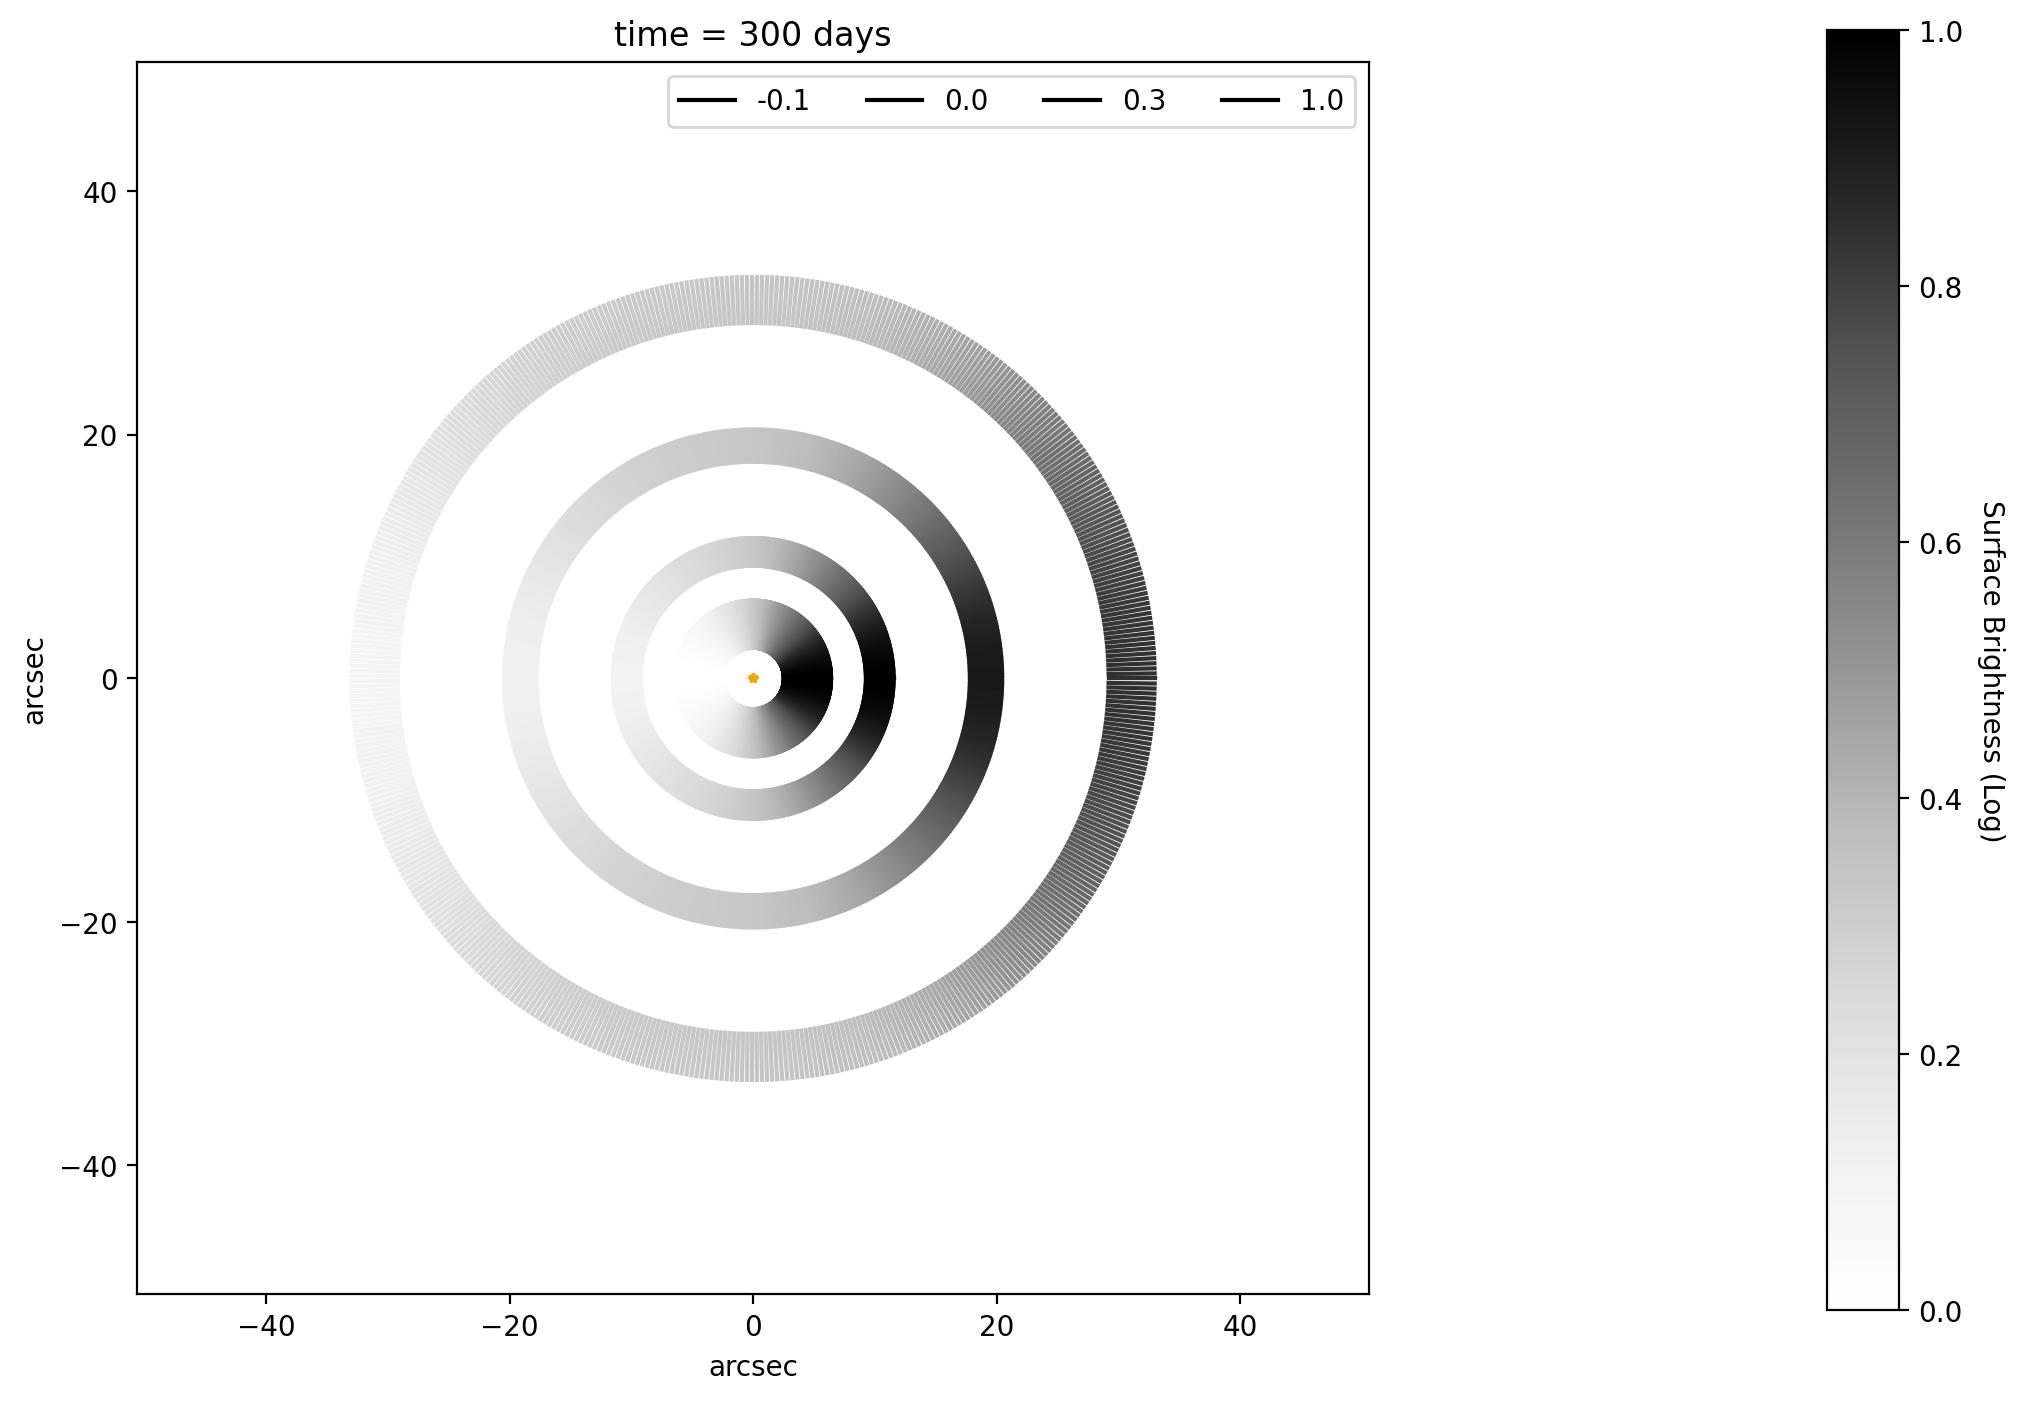

In [43]:
surface, Nd = final_plot(300, phi_min = 0, phi_max = 2 * np.pi, size_phi = 500, func = np.cos, k = 1, density_func =  nh_phi_plus_xx_dependence,
                         surface_func = surface_brightness_plane_x)


# Density = nH * func(ɸ) * (func(ɸ) $^2$ + func(ɸ))

In [44]:
def nh_phi_plus_dependence(params, k = 1, n_h = n):
  """
    Define the density as a pairwise function that depends on the angle phi, the angle in the x,y sky plane
    Arguments
        params: list/array/tuple with the phi angle to be evaluate
        phi_min: min phi where the density value exist
        phi_max: min phi where the density value exist
        n_h: density value
    Return
        Value of the density with same shape as params
  """

  nh = n_h * params * (params ** 2 + params)
  nh = np.nan_to_num(nh, nan = np.inf)
  return nh

In [45]:
def surface_brightness_plane_phi(Deltat_y, z0ly, dz0, func, phi, density_func):
  """
    Arguments
        Deltat_y: time when the snap of the LE is taken by observer, in year
        z0ly: sitance of the dust in light-years
        dz0: thickness of the plane dust
        Nd: density
  """

  # phi = np.linspace(0, 2*np.pi, 100)
  # Nd = np.array([nh_phi_plus_power(phi, [phi_min[0], phi_min[1]], [phi_max[0], phi_max[1]], k = -2)]).reshape(2, 100)
  # print(len(Nd), Nd.shape)
  surface = np.zeros((len(Deltat_y), len(z0ly), len(phi)))
  if isinstance(func, (int, float)):
    Nd = np.array([density_func(func * phi, k)]).reshape(1, len(phi))
  elif callable(func):
    Nd = np.array([density_func(func(phi), k)]).reshape(1, len(phi))
  print(surface.shape)
  for j, time in enumerate(Deltat_y):
    ct = time * c
    for i, z in enumerate(z0ly):
      if z < 0:
        # print(z)
        ti = (-2 * z)/(c * (1 + a**2))
        print(ti)
        if time >= ti:
          # print(z)
          r_le = np.sqrt(2 * z * ct + (ct)**2 * (1 + a**2) )
          # print(r_le)
          x = r_le * np.cos(phi) - a * ct
          # -- distance source - dust
          r = z - a * x + ct
          # -- rho = x^2 + y^2 = r_le
          rhodrho  = 0.5 * (dz0 - a * x + c * dt0)
          # print(len(x), len(theta))
          surface[j, i, :] = Ir * Nd * dz0 / ( 4 * np.pi * r * rhodrho)
        elif time < ti:
          print(time, j, i)
          surface[j, i, :] = Ir * np.zeros(len(phi))
          # print((surface[j, i, :]))
      elif z >= 0:
        ti = 0
        if time >= 0:
          # print(j, i)
          r_le = np.sqrt(2 * z * ct + (ct)**2 * (1 + a**2))
          # print((ct / c) / dtoy)
          x = r_le * np.cos(phi) - a * ct
          # print(x, np.cos(phi))
          # -- distance source - dust
          r = z - a * x + ct
          # print(r)
          # -- rho = x^2 + y^2 = r_le
          rhodrho  = 0.5 * (dz0 - a * x + c * dt0)
          # print(rhodrho)
          surface[j, i, :] = Ir * Nd * dz0 / ( 4 * np.pi * r * rhodrho)
          # print(j, i, Nd, surface[j, i, :])


  surface = surface.reshape(len(Deltat), len(z0ly), max(Nd.shape))
  # print((surface[0, 3, :]))

  # print(surface.shape)

  # surface_norm = (mean - np.nanmin(mean)) / (np.nanmax(mean) - np.nanmin(mean))
  # surface_norm = np.array(surface_norm).reshape(len(Deltat),len(z0ly), max(Nd.shape))

  return surface


(500,)
(1, 4, 500)
0.652312


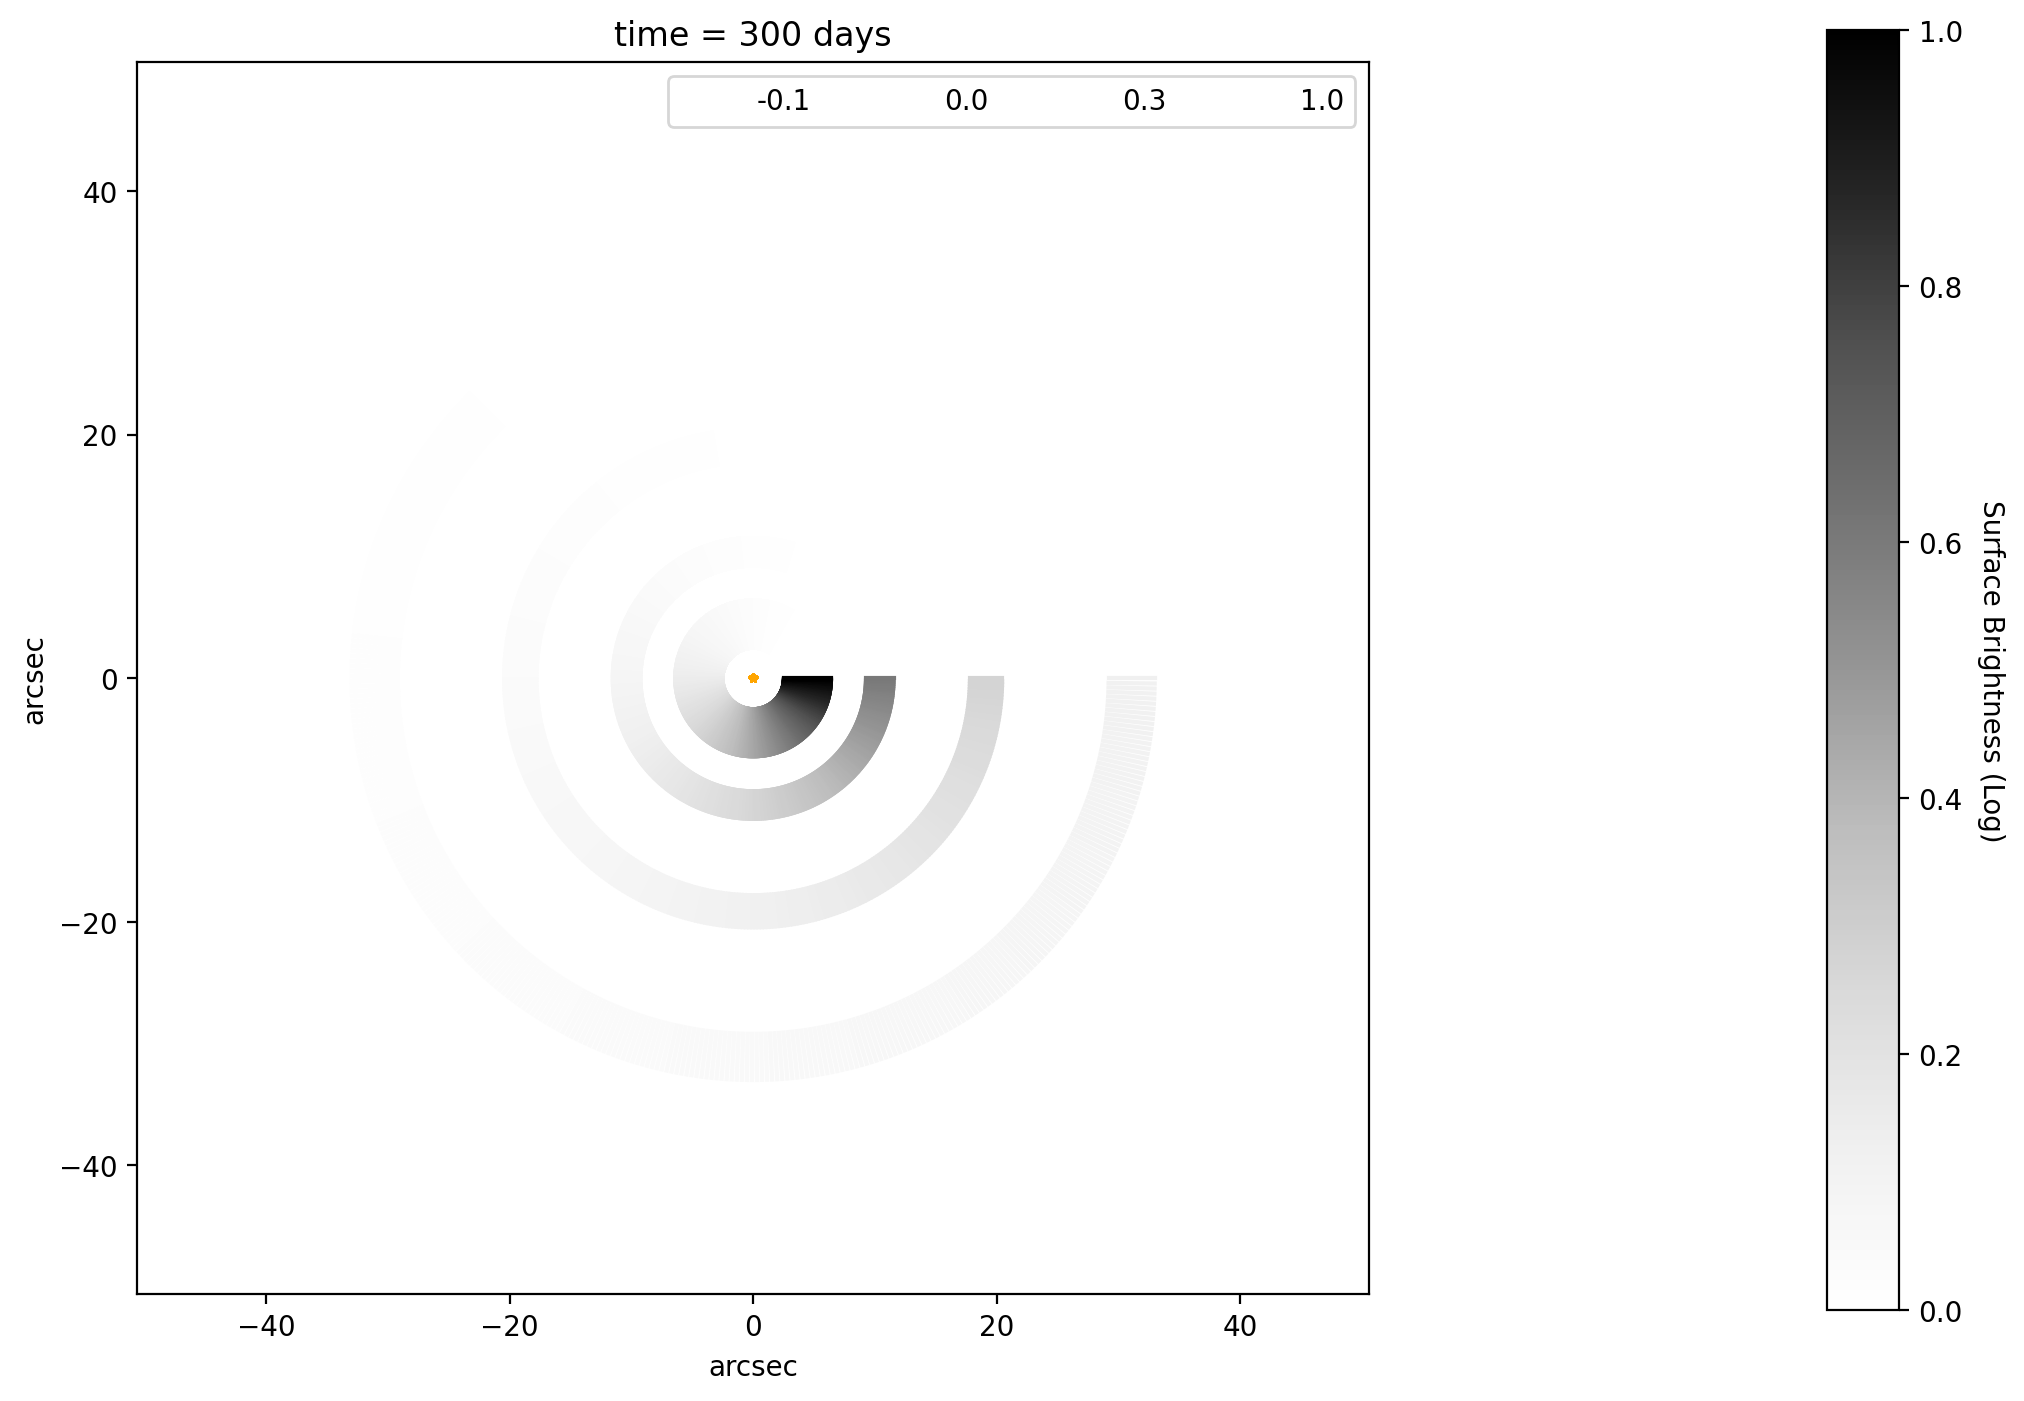

In [46]:
surface, Nd = final_plot(300, phi_min = 0, phi_max = 2 * np.pi, size_phi = 500, func = 1, k = 1, density_func =  nh_phi_plus_dependence,
                         surface_func = surface_brightness_plane_phi)